In [ ]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Configuration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Features of interest
selected_features = [
    "total_commits", "sum_lines_added", "sum_lines_deleted",
    "active_days", "last_minute_commits", "merged_requests",
    "review_comments_given", "review_comments_received",
    "issue_participation", "commit_efficiency"
]

# Loop through intervals
for i in range(1, 6):
    print("="*80)
    print(f"📊 Regression Matrix - Interval {i}")
    print("="*80)

    # Load data
    file_path = f"student_features_interval_{i}.csv"
    df = pd.read_csv(file_path)

    # Create commit_efficiency if needed
    if "commit_efficiency" not in df.columns and "sum_lines_added" in df.columns and "total_commits" in df.columns:
        df["commit_efficiency"] = df["sum_lines_added"] / df["total_commits"].replace(0, np.nan)

    # Drop rows with missing grades
    df = df.dropna(subset=["Final Grade"])

    # Compute regression coefficients
    features_in_data = [f for f in selected_features if f in df.columns]
    regression_results = {}

    for feature in features_in_data:
        X = df[[feature]].values
        y = df["Final Grade"].values
        if np.isnan(X).any() or np.isnan(y).any():
            continue
        model = LinearRegression()
        model.fit(X, y)
        regression_results[feature] = round(model.coef_[0], 3)

    # Display regression matrix
    reg_df = pd.DataFrame.from_dict(regression_results, orient="index", columns=["Coefficient"])
    reg_df.sort_values(by="Coefficient", ascending=False, inplace=True)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=reg_df["Coefficient"], y=reg_df.index, palette="viridis")
    plt.axvline(0, color="gray", linestyle="--")
    plt.title(f"📈 Linear Regression Coefficients vs Final Grade - Interval {i}")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.preprocessing import RobustScaler
from scipy.stats import zscore

X_all = []
y_all = []

# Features to analyze
selected_features = [
    "total_commits", "sum_lines_added", "sum_lines_deleted",
    "active_days", "last_minute_commits", "merged_requests",
    "review_comments_given", "review_comments_received",
    "issue_participation", "commit_efficiency"
]

# Loop over the 5 intervals
for i in range(1, 6):
    print("="*80)
    print(f"📁 EDA for Interval {i}")
    print("="*80)

    # ------------------------------
    # 1. Load Dataset
    file_path = f"student_features_interval_{i}.csv"
    df = pd.read_csv(file_path)

    # ------------------------------
    # 2. Compute commit_efficiency if missing
    if "commit_efficiency" not in df.columns and "sum_lines_added" in df.columns and "total_commits" in df.columns:
        df["commit_efficiency"] = df["sum_lines_added"] / df["total_commits"].replace(0, np.nan)

    # ------------------------------
    # 3. Check for Duplicates
    duplicates = df[df.duplicated()]
    print(f"🔁 Duplicates found in Interval {i}: {len(duplicates)}")
    if not duplicates.empty:
        display(duplicates)

    # ------------------------------
    # 4. Correlation Matrix
    cols_for_corr = [f for f in selected_features + ["Final Grade"] if f in df.columns]
    corr = df[cols_for_corr].select_dtypes(include='number').corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title(f"🔗 Correlation Matrix (Selected Features) - Interval {i}")
    plt.tight_layout()
    plt.show()

    # ------------------------------
    # 5. Drop NaNs and prepare subset
    df_sub = df[cols_for_corr].dropna()

    # ------------------------------
    # 6. Outlier Removal (Z-Score + Fallback)
    features_in_data = [f for f in selected_features if f in df_sub.columns]
    z_scores = np.abs(zscore(df_sub[features_in_data], nan_policy='omit'))
    mask = (z_scores < 3).all(axis=1)
    df_no_outliers = df_sub[mask]

    if df_no_outliers.shape[0] == 0:
        print(f"⚠️ Interval {i}: All rows removed as outliers. Using original data without removal.")
        df_no_outliers = df_sub.copy()

    print(f"📉 Rows before: {df_sub.shape[0]} ➝ after outlier removal: {df_no_outliers.shape[0]}")

    # ------------------------------
    # 7. Normalize (RobustScaler)
    scaler = RobustScaler()
    features_in_data = [f for f in selected_features if f in df_no_outliers.columns]
    
    if df_no_outliers.shape[0] == 0 or len(features_in_data) == 0:
        print(f"⚠️ Interval {i}: Skipping due to lack of valid data.")
        continue

    X = scaler.fit_transform(df_no_outliers[features_in_data])
    y = df_no_outliers["Final Grade"].values

    X_all.append(X)
    y_all.append(y)

    # ------------------------------
    # 8. Feature Distributions
    for feature in selected_features:
        if feature in df_no_outliers.columns:
            plt.figure()
            sns.histplot(df_no_outliers[feature], kde=True, bins=20)
            plt.title(f"📊 Distribution of {feature} (Interval {i})")
            plt.xlabel(feature)
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

    # ------------------------------
    # 9. Feature vs Final Grade
    for feature in selected_features:
        if feature in df_no_outliers.columns:
            plt.figure()
            sns.scatterplot(x=df_no_outliers[feature], y=df_no_outliers["Final Grade"])
            plt.title(f"📈 {feature} vs Final Grade - Interval {i}")
            plt.xlabel(feature)
            plt.ylabel("Final Grade")
            plt.tight_layout()
            plt.show()

    # ------------------------------
    # 10. Grade by Group (if exists)
    if "group_id" in df.columns:
        temp = df_no_outliers.copy()
        temp["group_id"] = df.loc[temp.index, "group_id"]
        plt.figure()
        sns.boxplot(x=temp["group_id"], y=temp["Final Grade"])
        plt.title(f"📦 Final Grade by Group - Interval {i}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


📁 EDA for Interval 1
🔁 Duplicates found in Interval 1: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:36: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


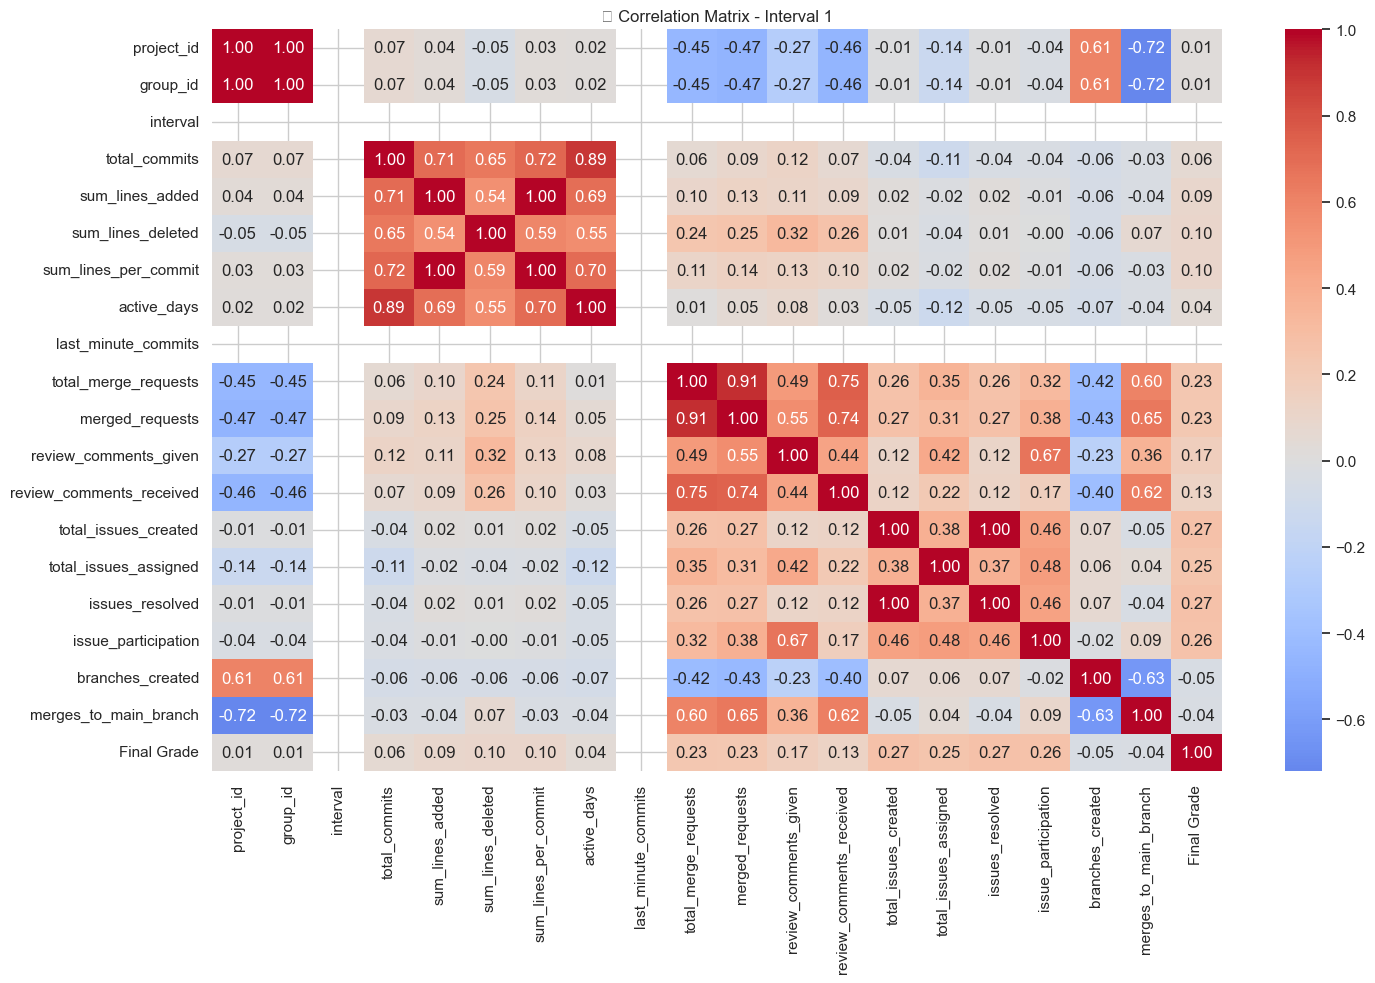

✅ Features selecionadas para o Intervalo 1 (|r| > 0.3): []
⚠️ Nenhuma feature com correlação significativa. A saltar este intervalo.
📁 EDA for Interval 2
🔁 Duplicates found in Interval 2: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:36: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


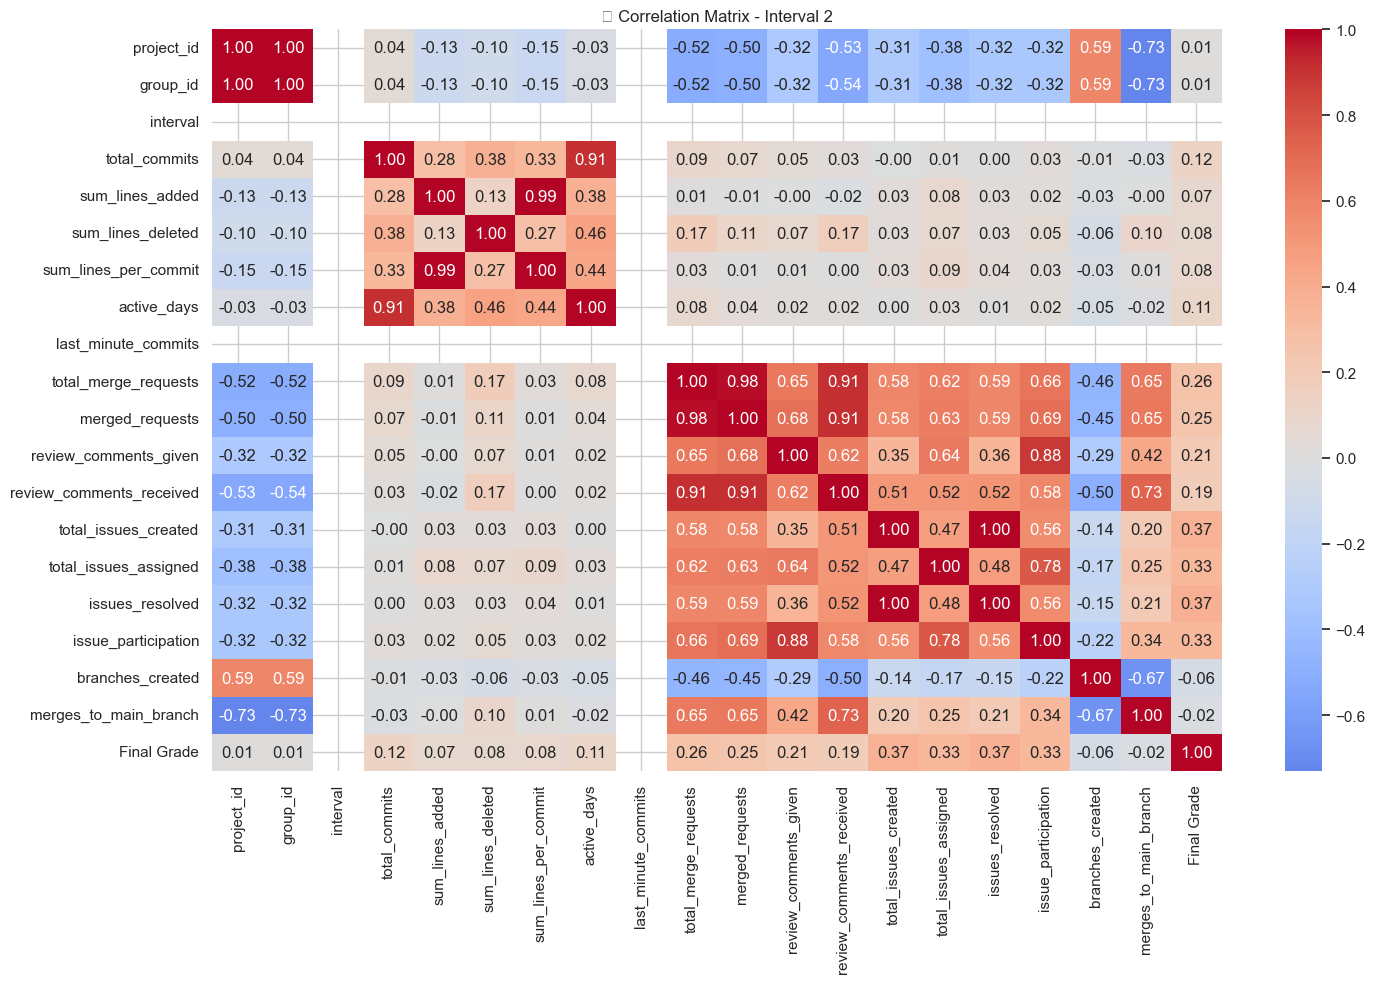

✅ Features selecionadas para o Intervalo 2 (|r| > 0.3): ['issues_resolved', 'total_issues_created', 'issue_participation', 'total_issues_assigned']
📉 Remoção de outliers: 216 ➝ 201 linhas


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


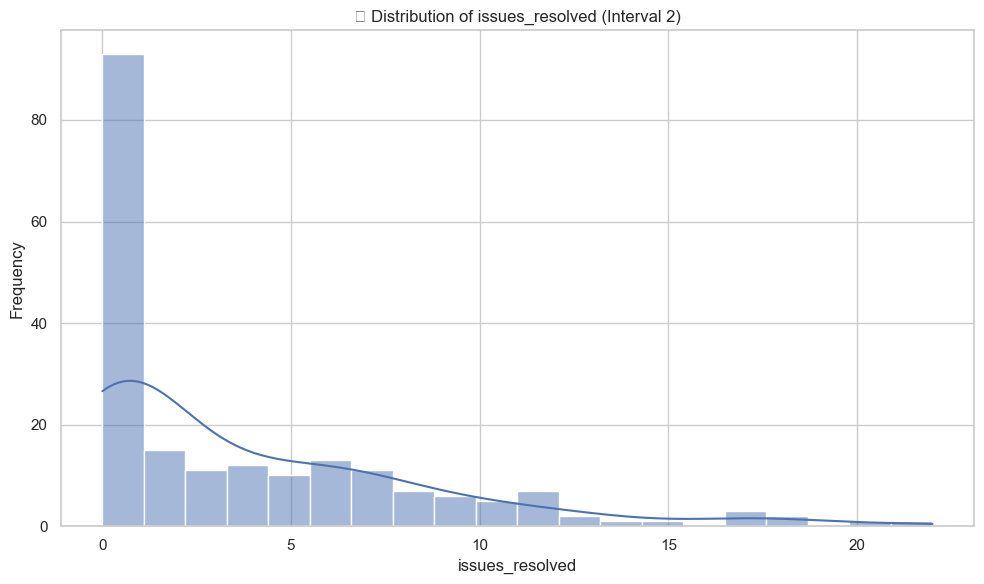

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


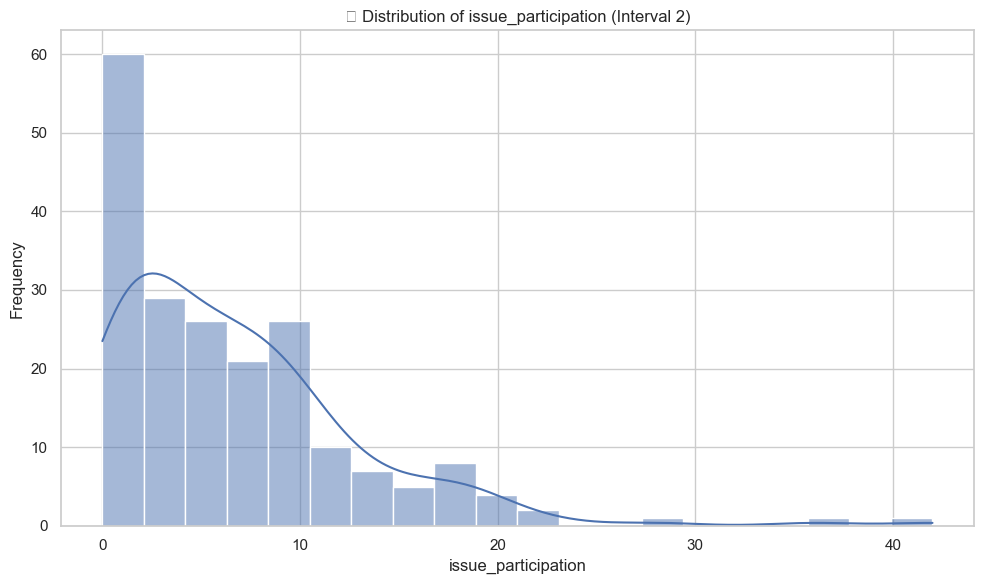

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


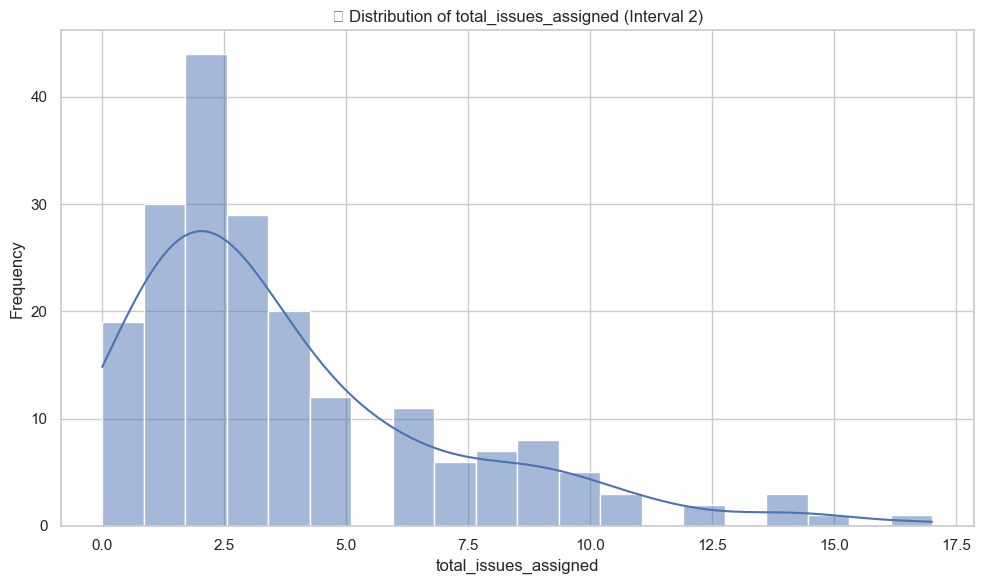

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:97: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


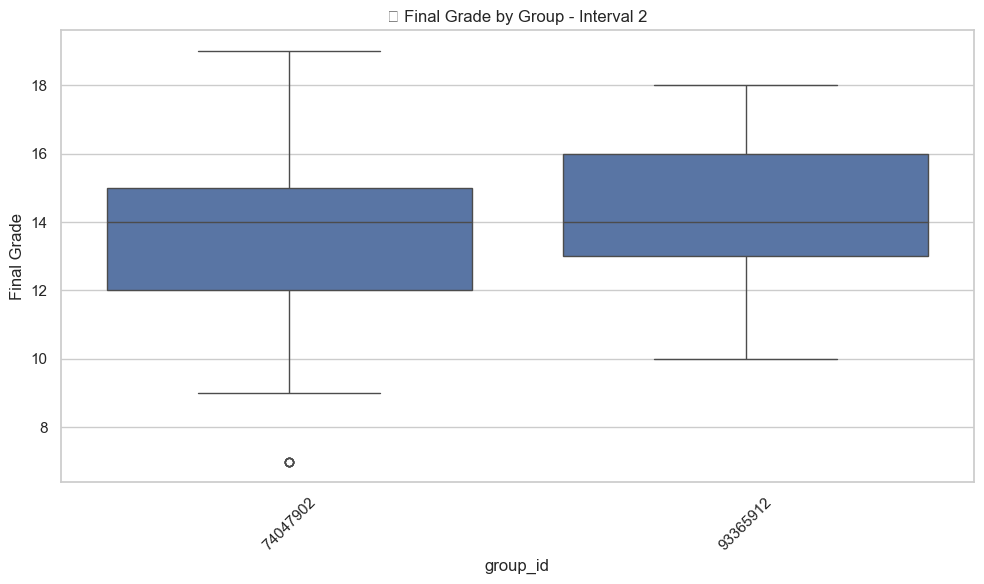

📁 EDA for Interval 3
🔁 Duplicates found in Interval 3: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:36: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Features selecionadas para o Intervalo 3 (|r| > 0.3): ['total_issues_assigned', 'issue_participation', 'issues_resolved', 'total_issues_created']
📉 Remoção de outliers: 225 ➝ 213 linhas


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


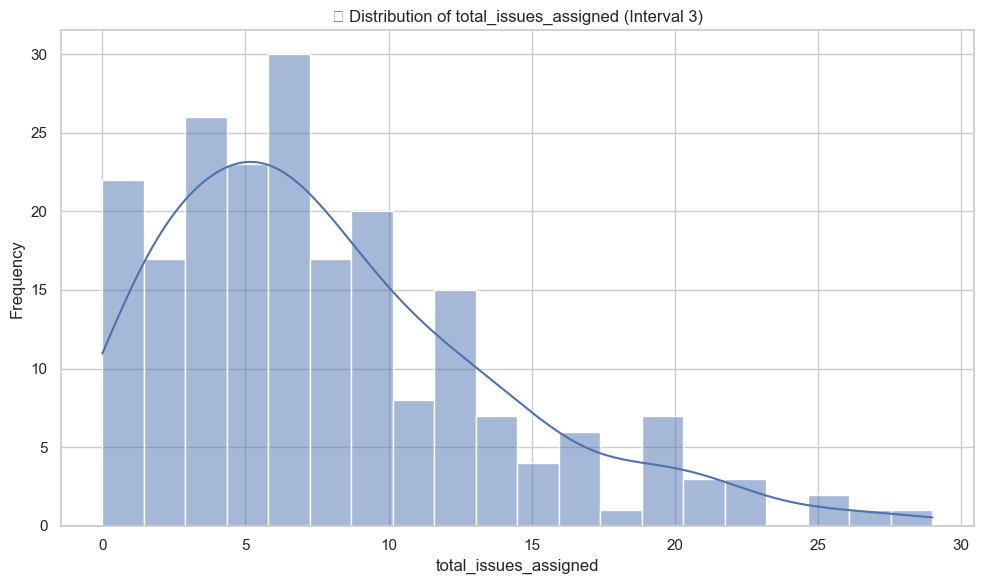

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


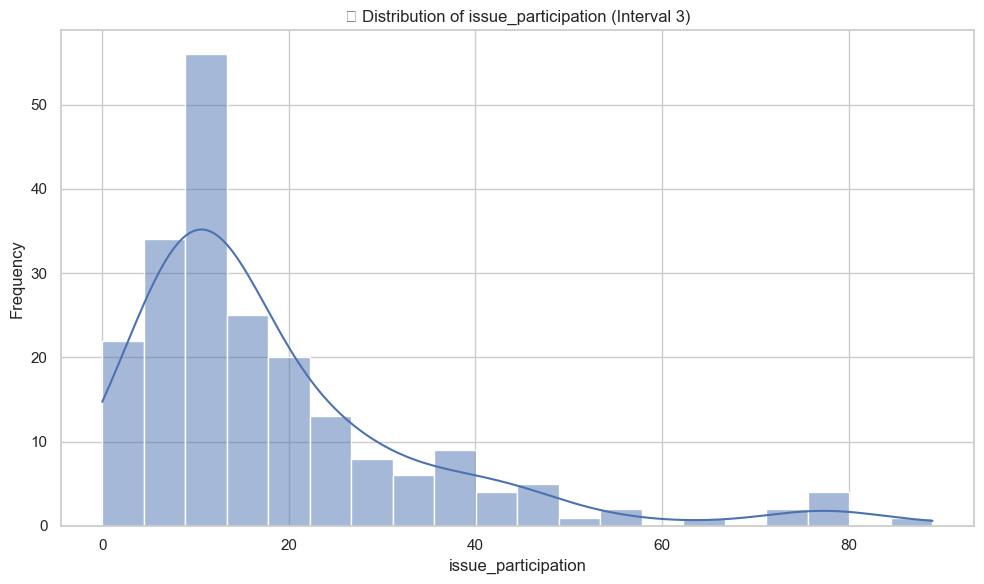

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


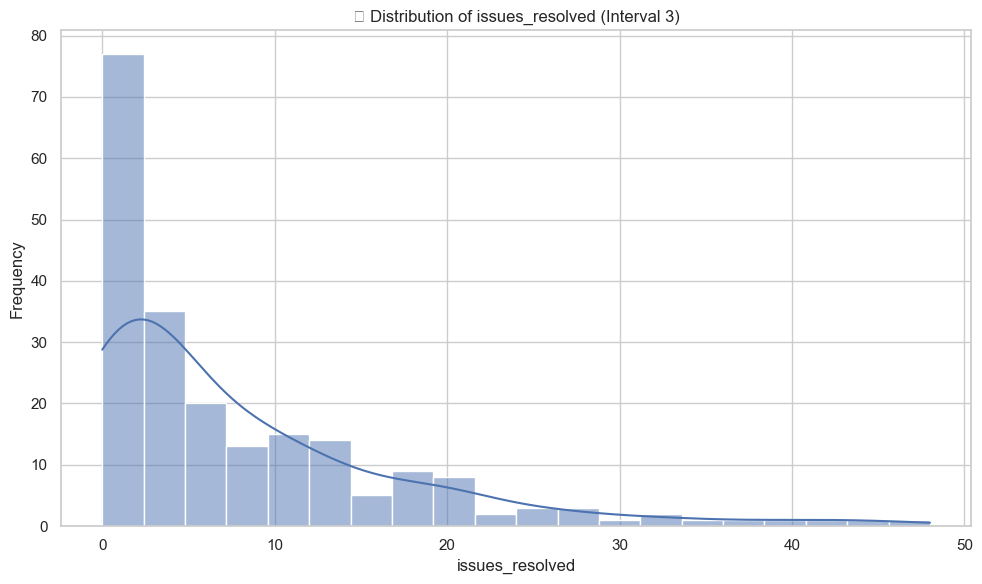

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


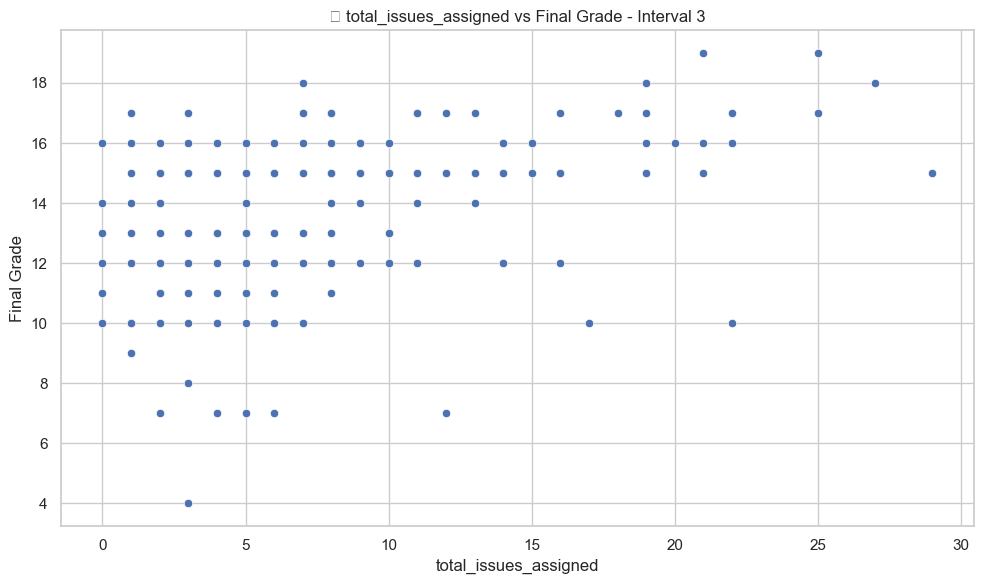

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


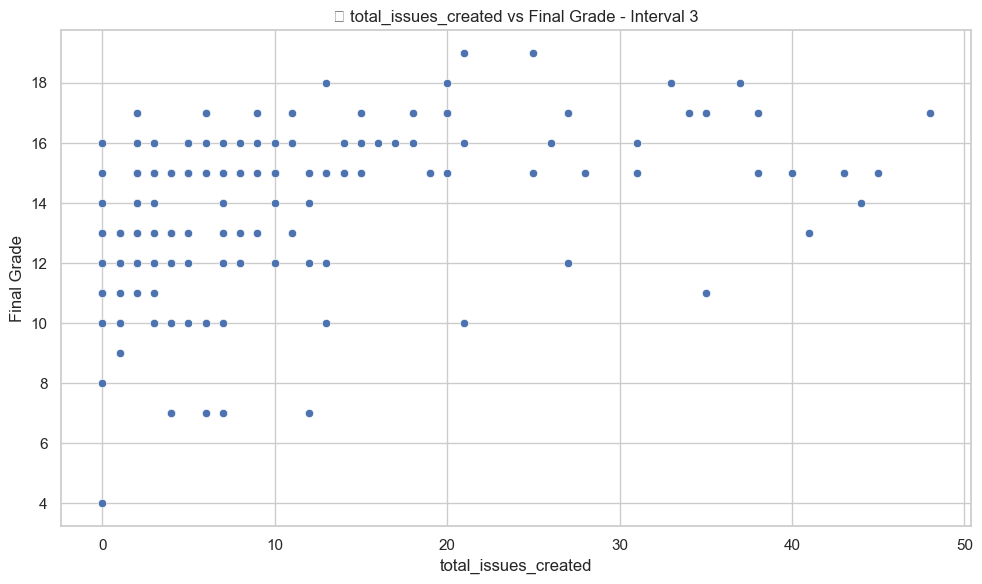

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:97: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


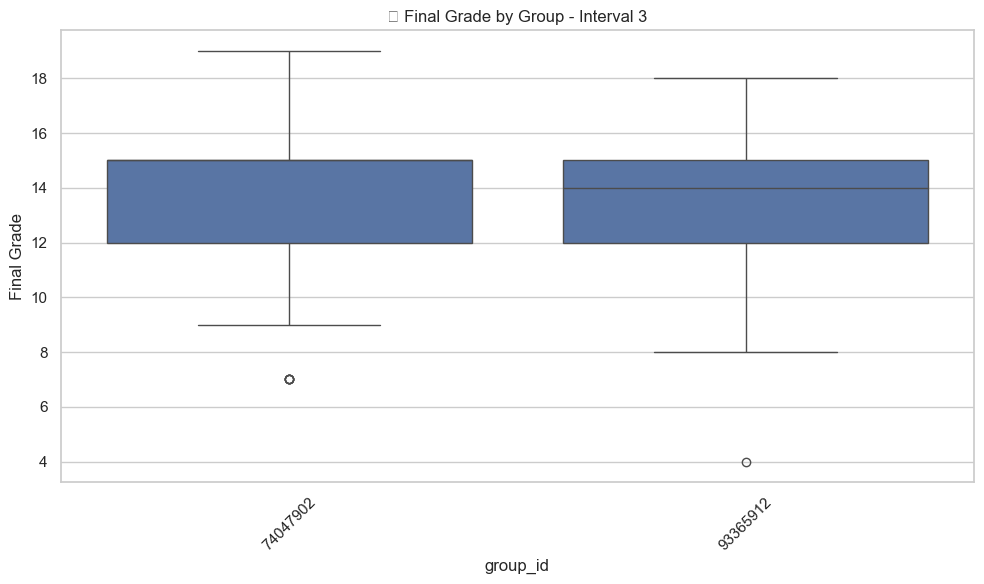

📁 EDA for Interval 4
🔁 Duplicates found in Interval 4: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:36: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Features selecionadas para o Intervalo 4 (|r| > 0.3): ['total_issues_assigned', 'issue_participation', 'issues_resolved', 'total_issues_created']
📉 Remoção de outliers: 225 ➝ 212 linhas


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


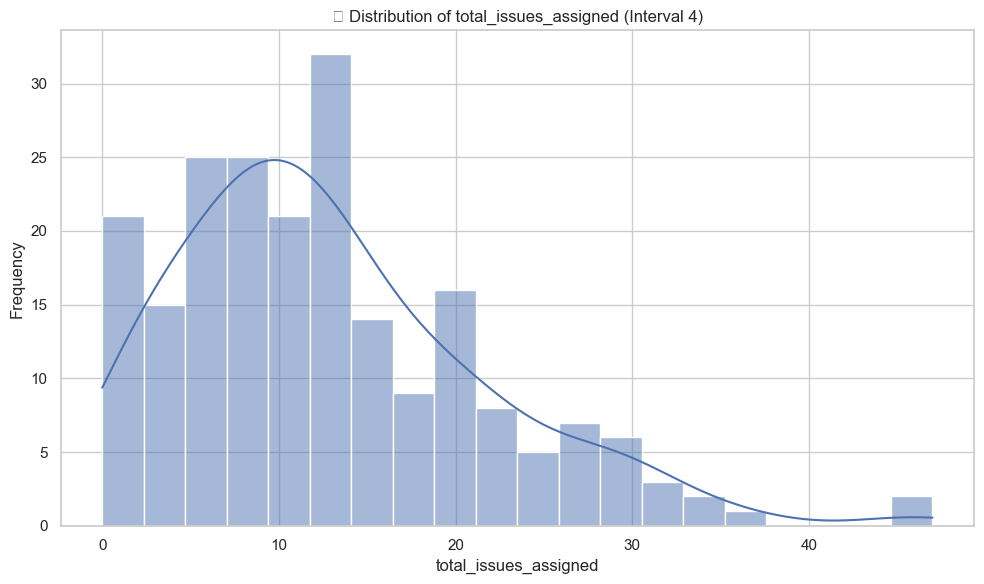

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


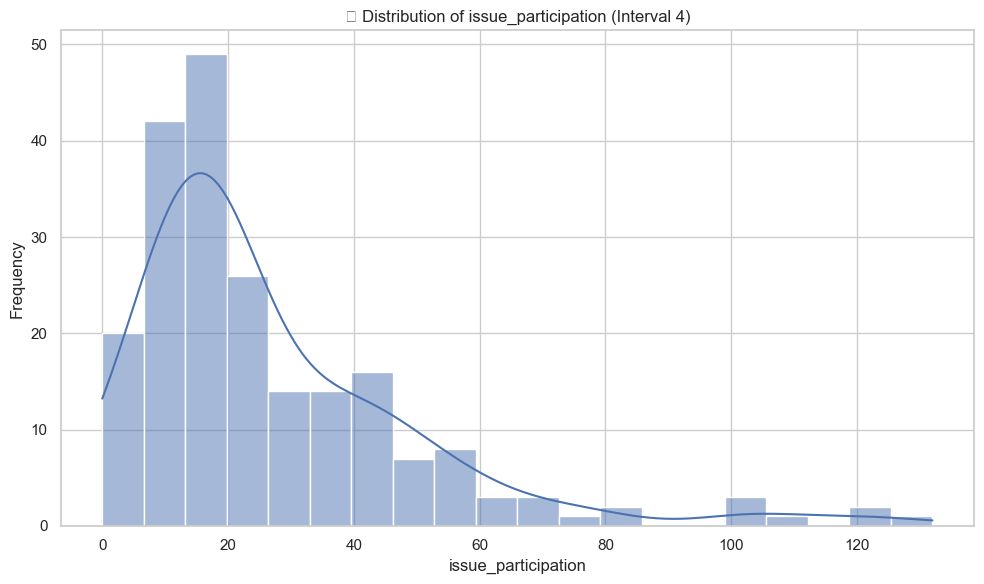

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


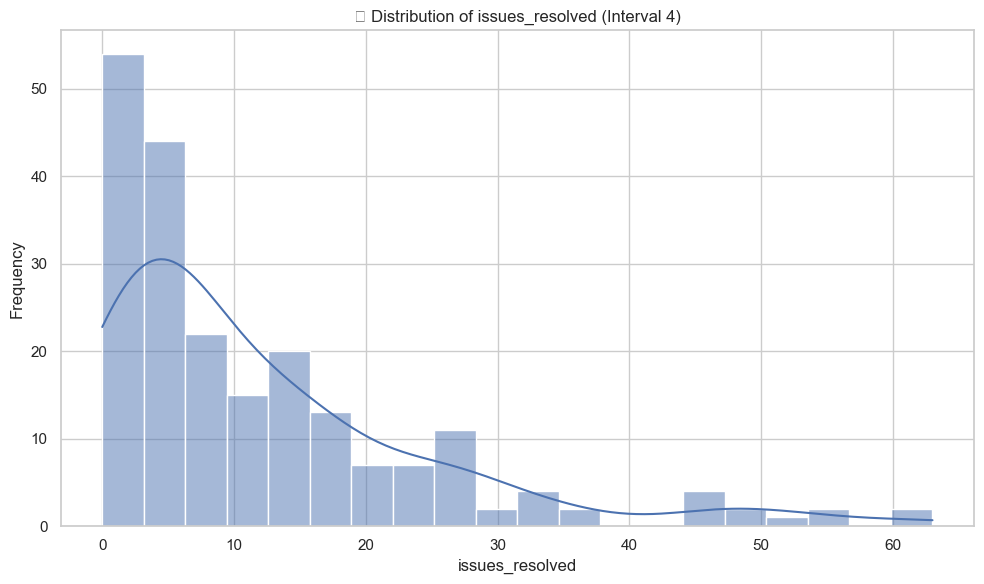

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


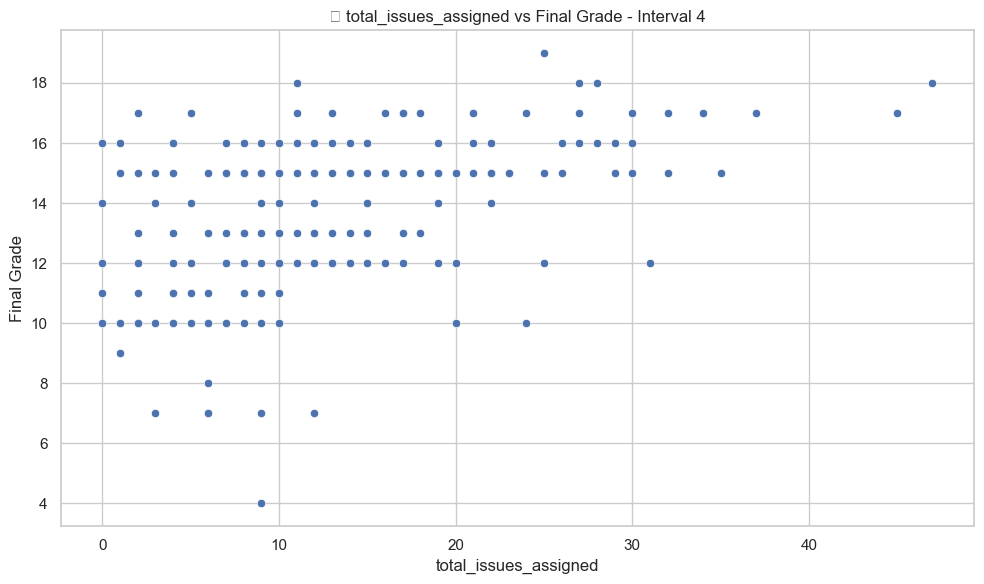

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


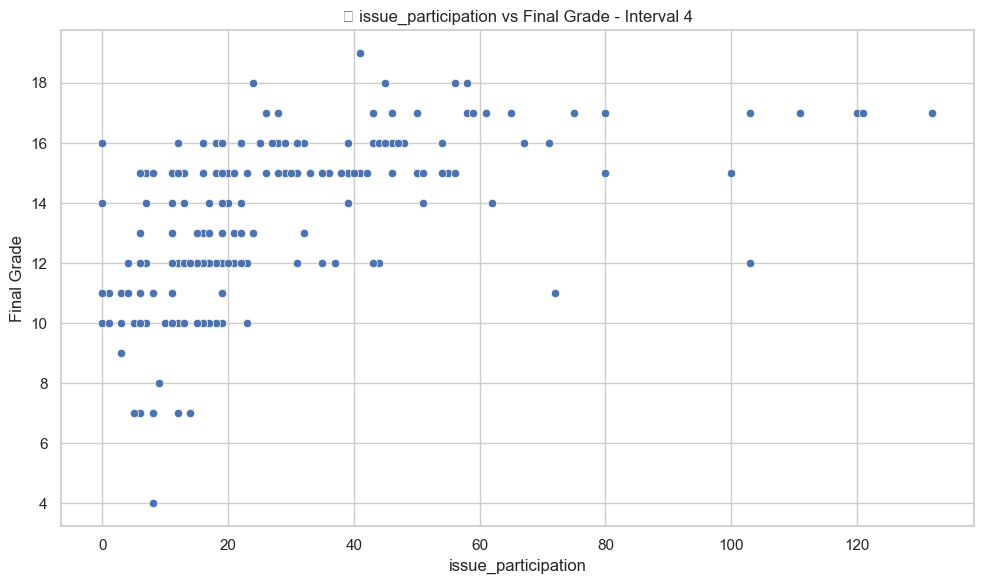

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


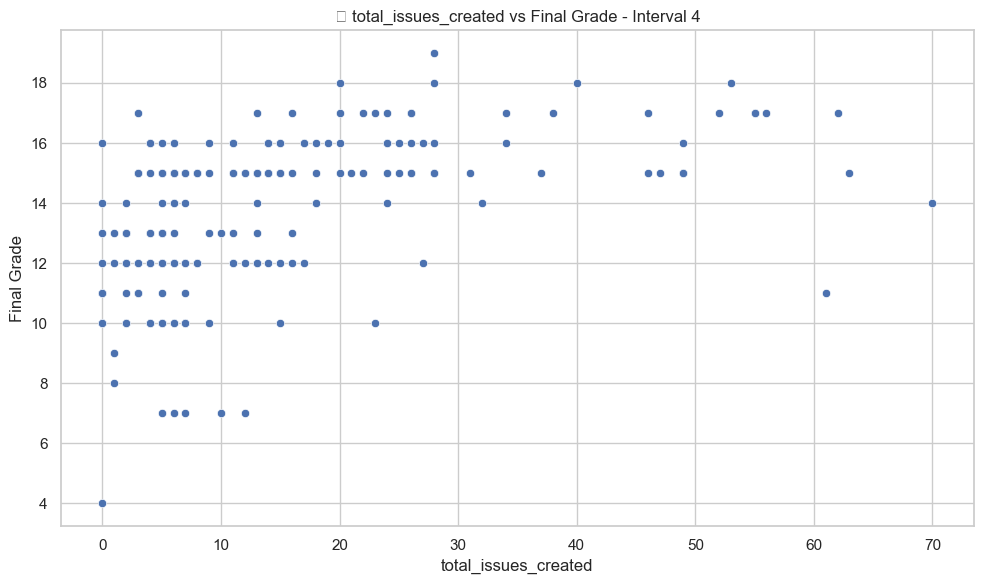

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:97: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


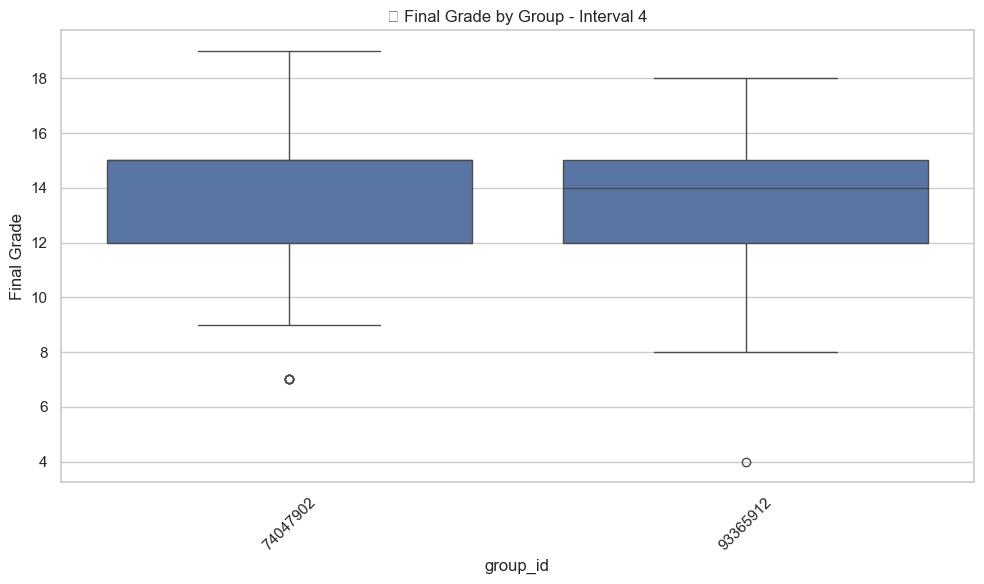

📁 EDA for Interval 5
🔁 Duplicates found in Interval 5: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:36: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


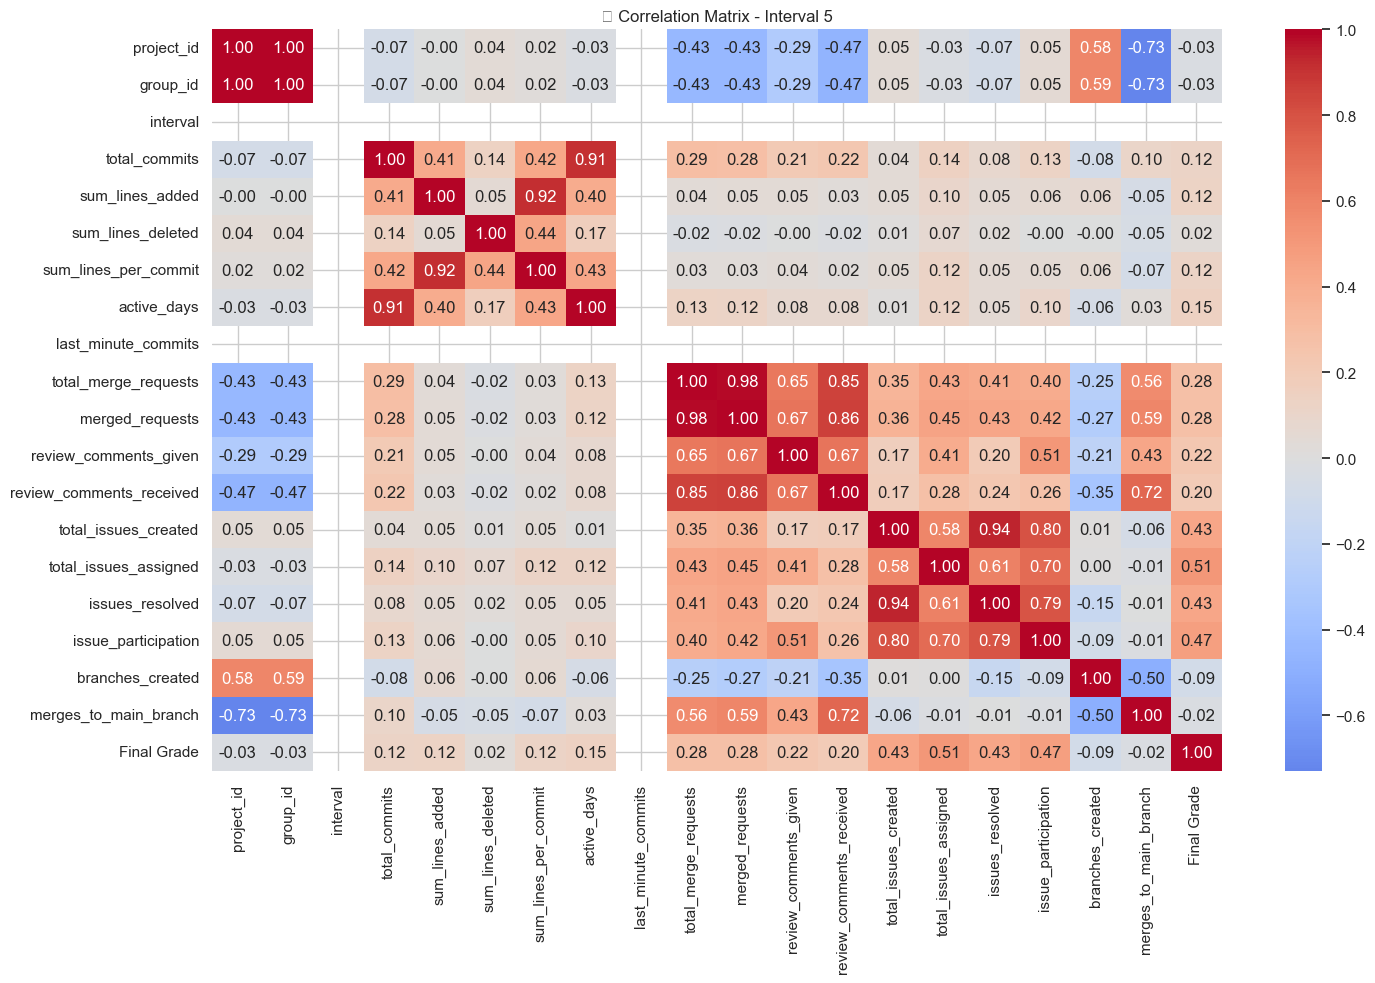

✅ Features selecionadas para o Intervalo 5 (|r| > 0.3): ['total_issues_assigned', 'issue_participation', 'issues_resolved', 'total_issues_created']
📉 Remoção de outliers: 225 ➝ 212 linhas


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:75: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


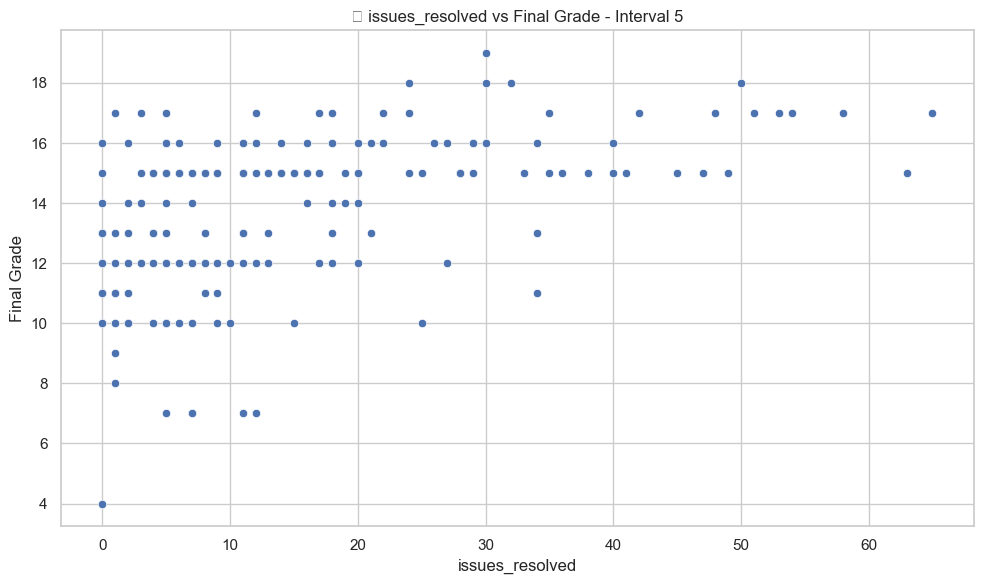

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:86: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


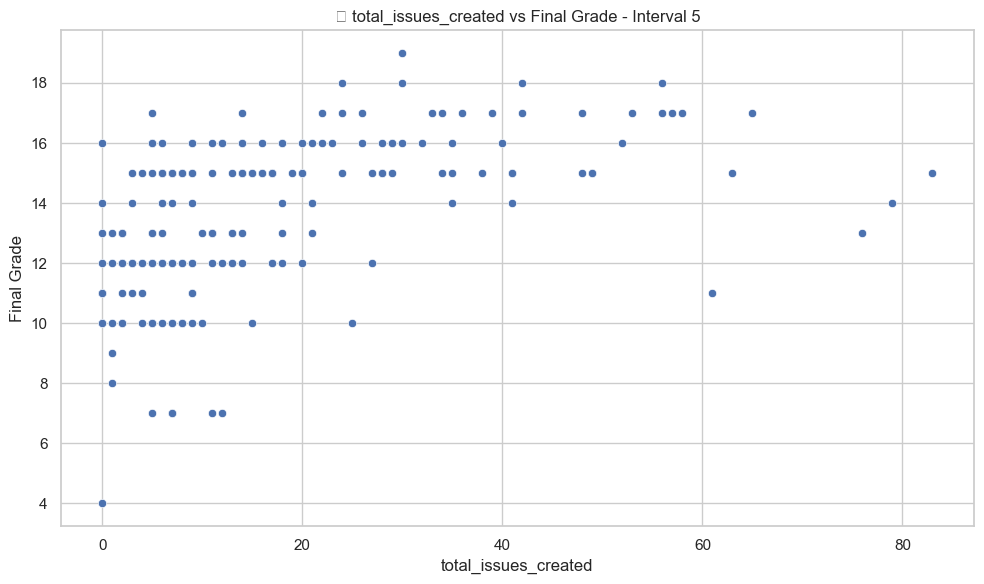

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1988395231.py:97: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


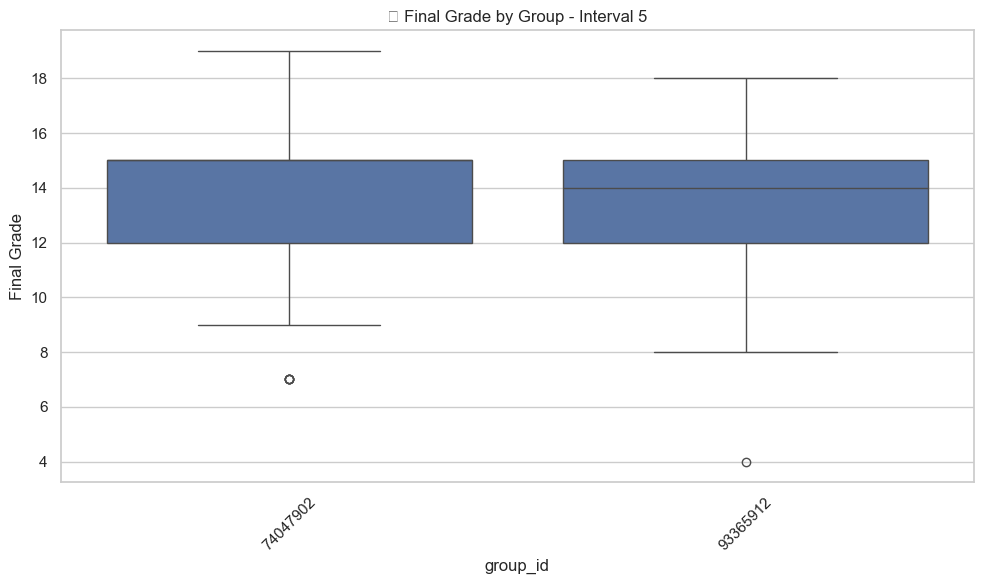

In [9]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Configuration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Loop over the 5 intervals
for i in range(1, 6):
    print("="*80)
    print(f"📁 EDA for Interval {i}")
    print("="*80)
    
    # Load dataset
    file_path = f"student_features_interval_{i}.csv"
    df = pd.read_csv(file_path)

    # ------------------------------
    # 1. Check for duplicates
    duplicates = df[df.duplicated()]
    print(f"🔁 Duplicates found in Interval {i}: {len(duplicates)}")
    if not duplicates.empty:
        display(duplicates)

    # ------------------------------
    # 2. Correlation matrix (antes da filtragem)
    corr = df.select_dtypes(include='number').corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title(f"🔗 Correlation Matrix - Interval {i}")
    plt.tight_layout()
    plt.show()

    # ------------------------------
    # 3. Seleção de features com base na correlação com Final Grade
    if "Final Grade" not in df.columns:
        print("⚠️ Final Grade não encontrada no dataset.")
        continue
    
    correlations = corr["Final Grade"].drop("Final Grade").sort_values(key=lambda x: abs(x), ascending=False)
    selected_features = correlations[abs(correlations) > 0.3].index.tolist()
    
    print(f"✅ Features selecionadas para o Intervalo {i} (|r| > 0.3): {selected_features}")

    if not selected_features:
        print("⚠️ Nenhuma feature com correlação significativa. A saltar este intervalo.")
        continue

    # ------------------------------
    # 4. Remoção de outliers (z-score)
    df_filtered = df[selected_features + ["Final Grade"]].dropna()
    z_scores = np.abs(zscore(df_filtered))
    df_no_outliers = df_filtered[(z_scores < 3).all(axis=1)]
    print(f"📉 Remoção de outliers: {df_filtered.shape[0]} ➝ {df_no_outliers.shape[0]} linhas")

    # ------------------------------
    # 5. Normalização (apenas features selecionadas)
    scaler = StandardScaler()
    X = scaler.fit_transform(df_no_outliers[selected_features])
    y = df_no_outliers["Final Grade"].values

    # ------------------------------
    # 6. Visualização das distribuições após limpeza
    for feature in selected_features:
        plt.figure()
        sns.histplot(df_no_outliers[feature], kde=True, bins=20)
        plt.title(f"📊 Distribution of {feature} (Interval {i})")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    # ------------------------------
    # 7. Feature vs Grade (scatterplots)
    for feature in selected_features:
        plt.figure()
        sns.scatterplot(x=df_no_outliers[feature], y=df_no_outliers["Final Grade"])
        plt.title(f"📈 {feature} vs Final Grade - Interval {i}")
        plt.xlabel(feature)
        plt.ylabel("Final Grade")
        plt.tight_layout()
        plt.show()

    # ------------------------------
    # 8. Boxplot: Grade by Group (se existir)
    if "group_id" in df.columns:
        temp = df.loc[df_no_outliers.index]
        plt.figure()
        sns.boxplot(x=temp["group_id"], y=temp["Final Grade"])
        plt.title(f"📦 Final Grade by Group - Interval {i}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


📁 EDA for Interval 1
🔁 Duplicates found in Interval 1: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:56: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


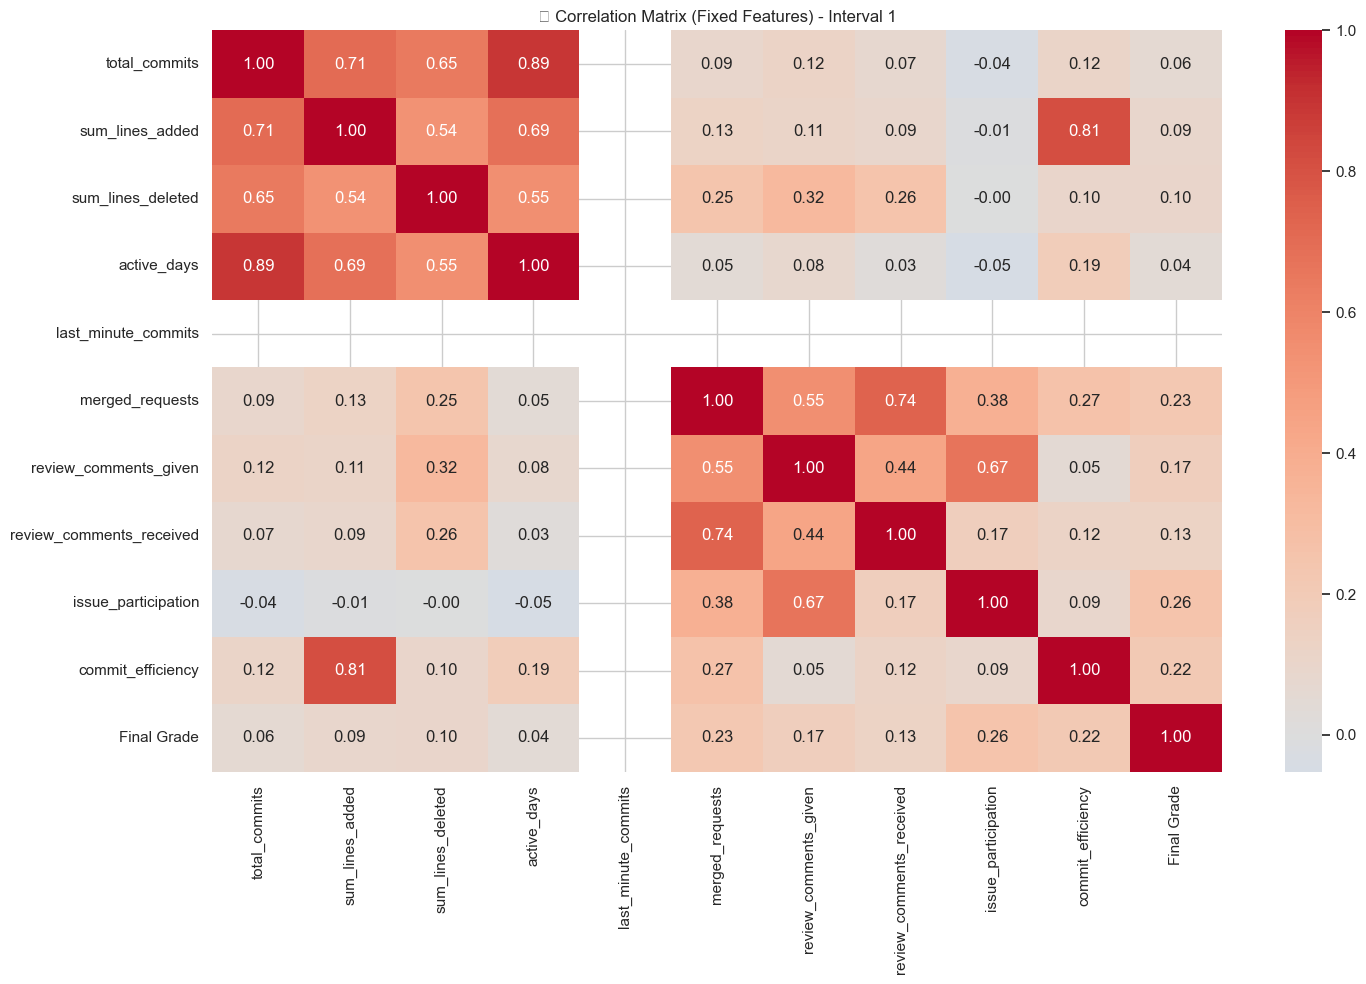

📉 Remoção de outliers (por feature): 44 ➝ 0 linhas
⚠️ Poucos dados após limpeza no Intervalo 1, a usar o dataset original sem remover outliers.


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


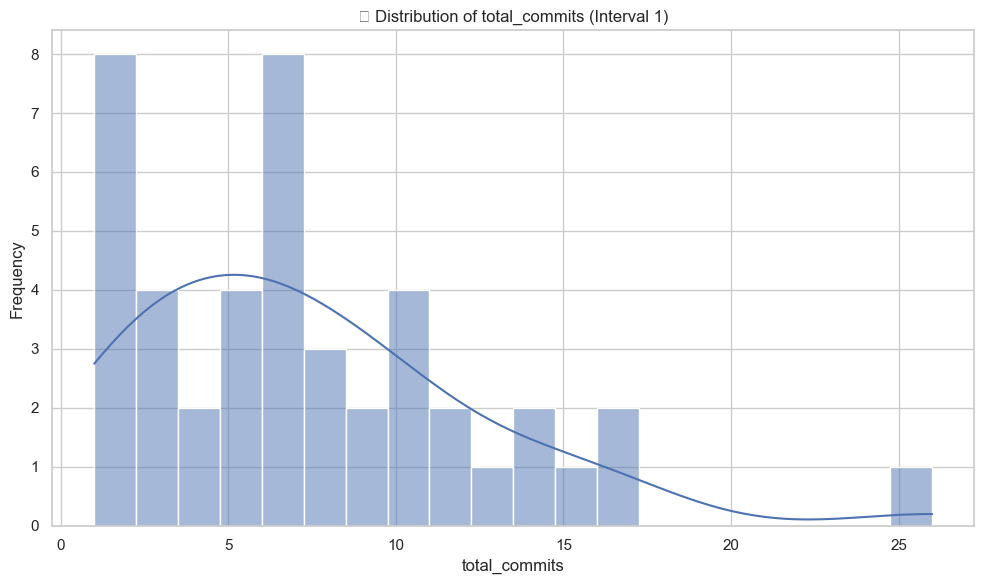

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


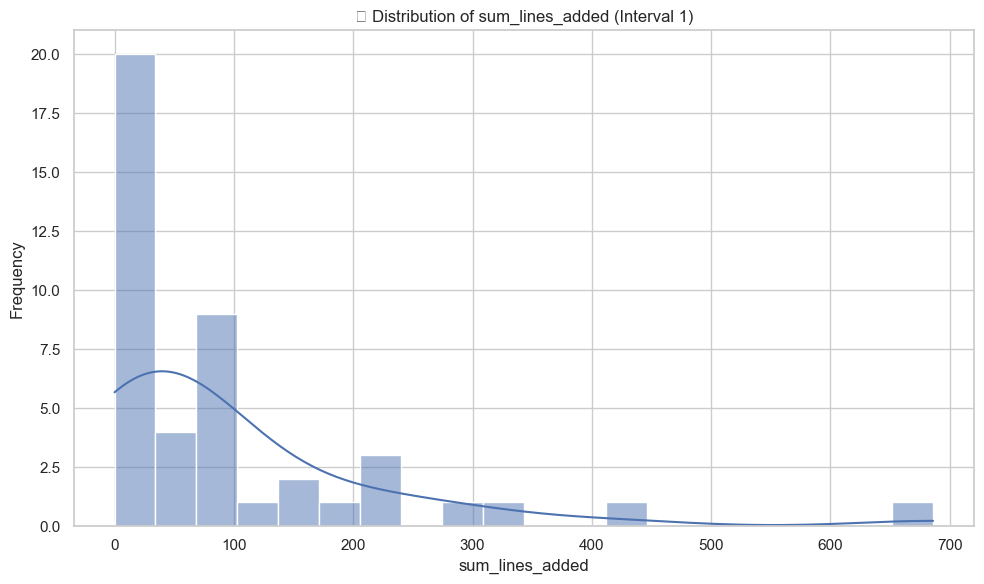

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


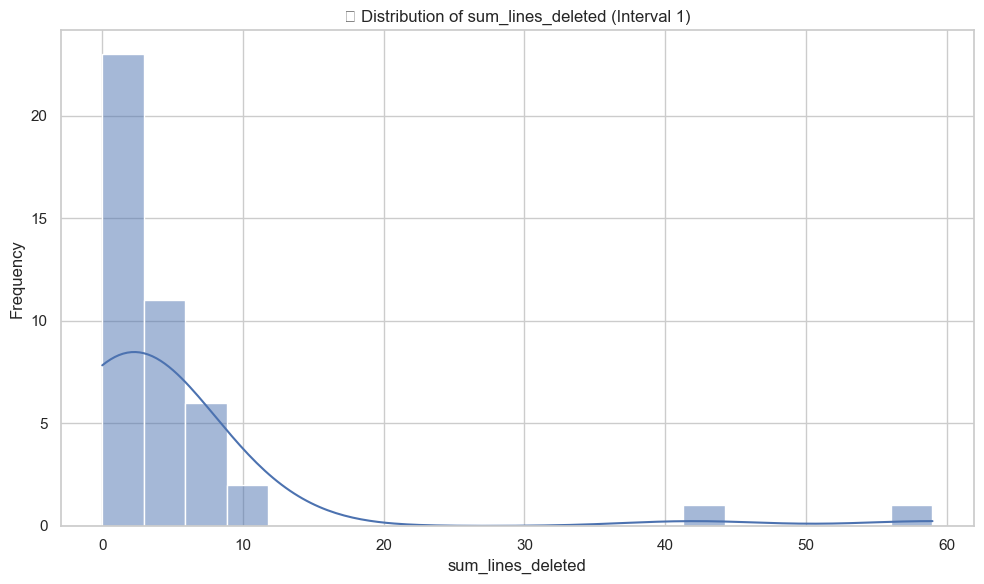

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


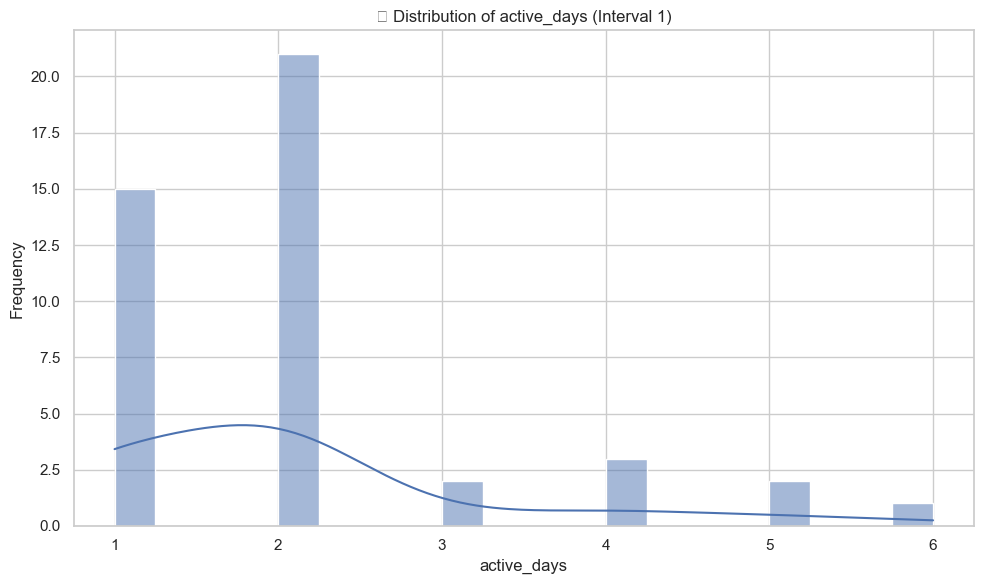

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


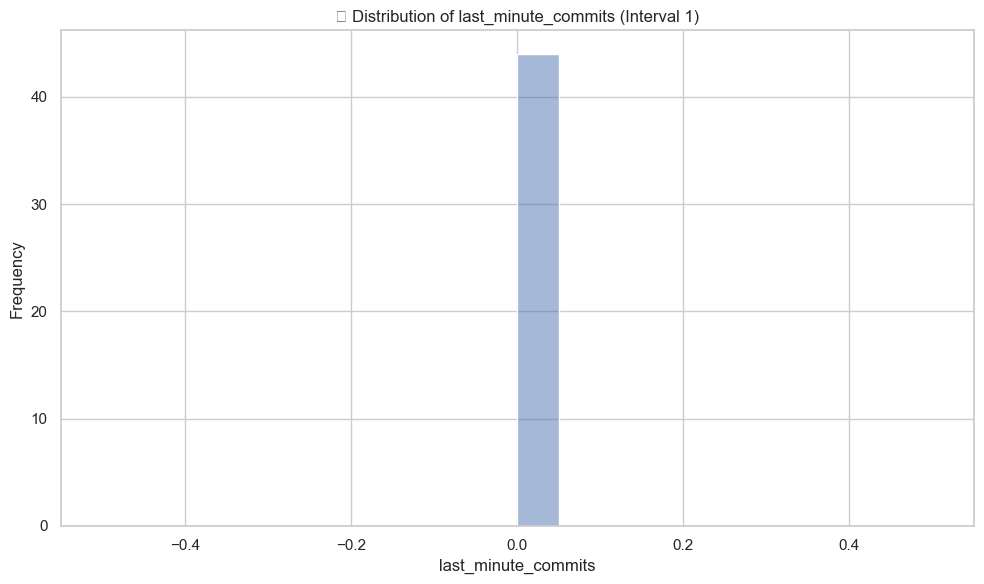

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


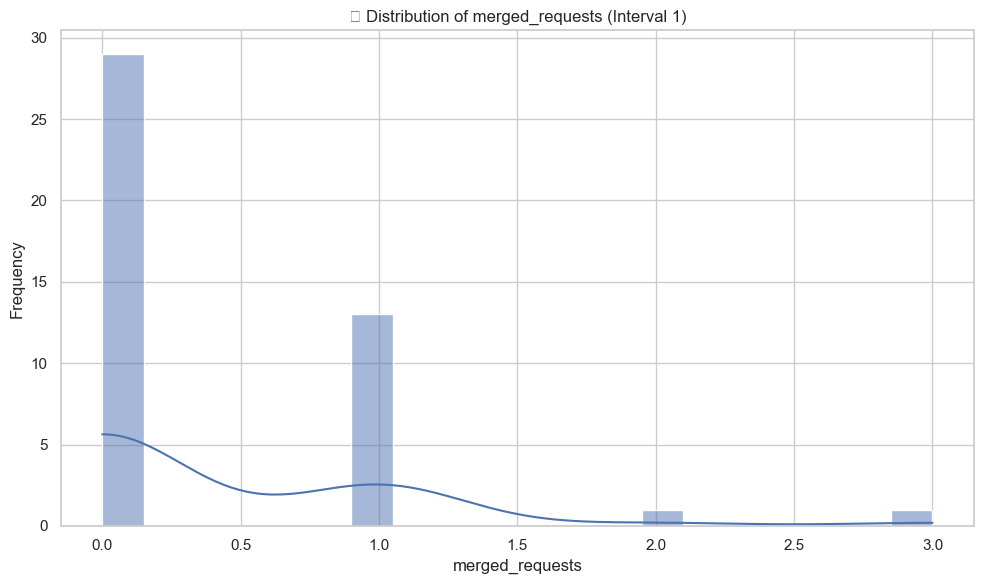

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


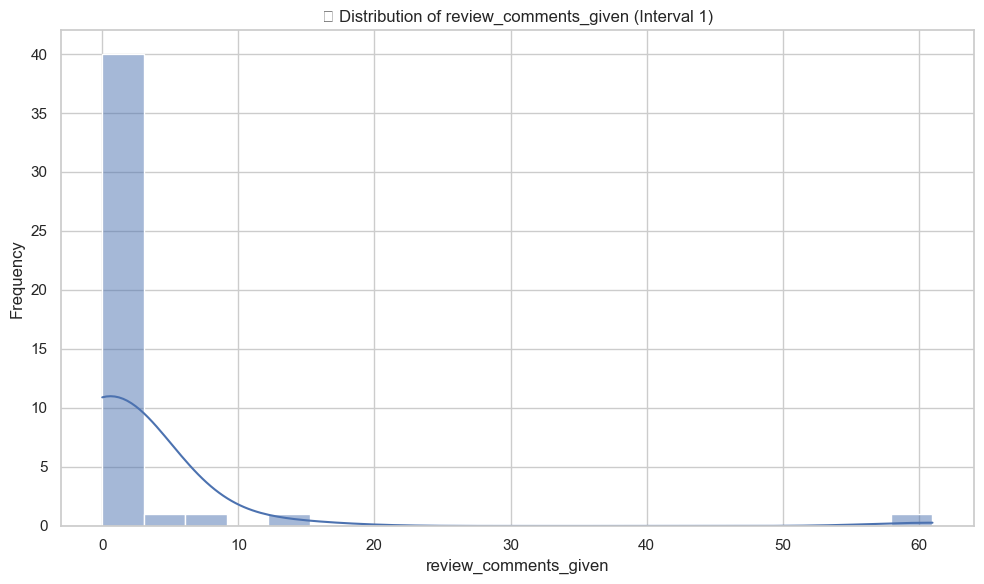

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


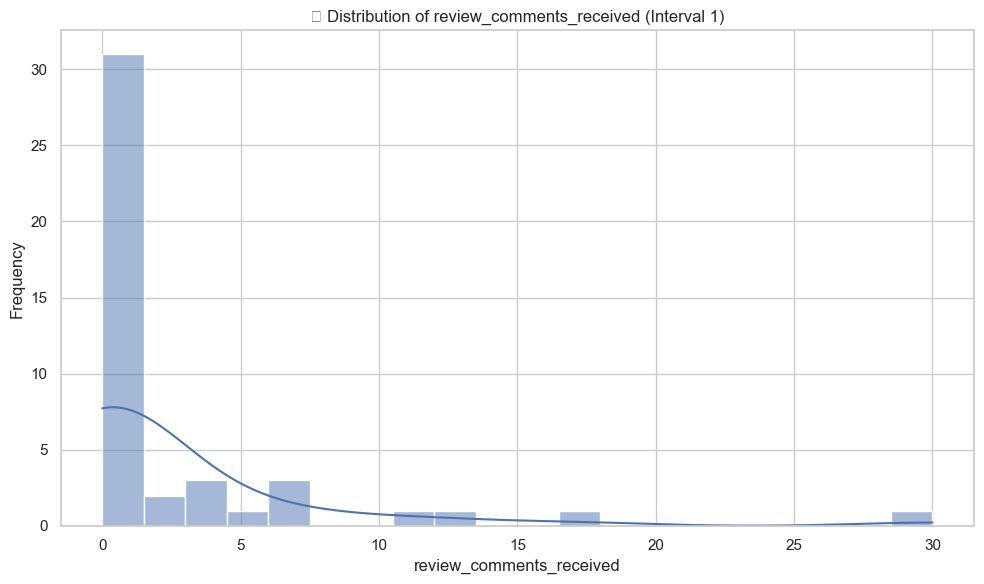

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


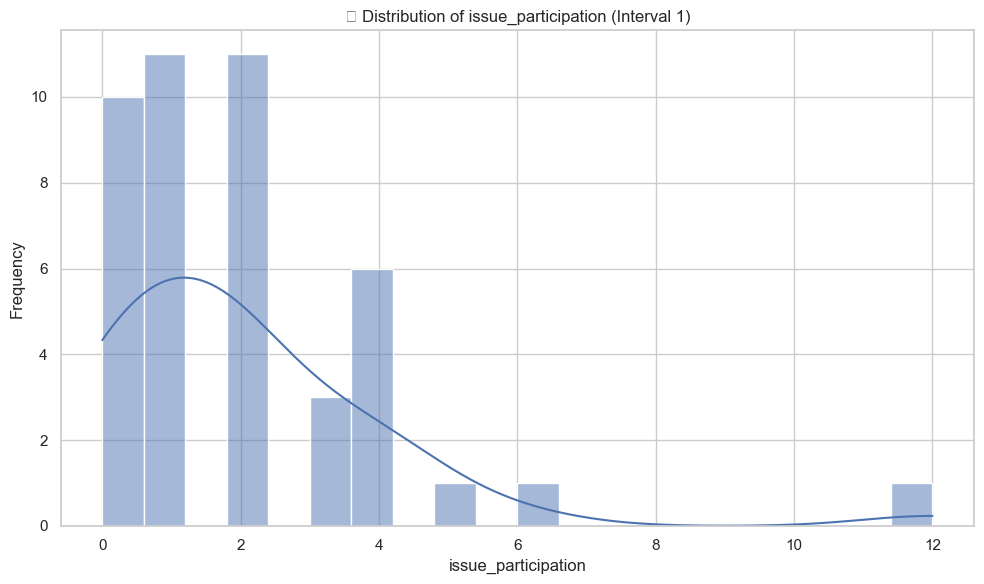

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


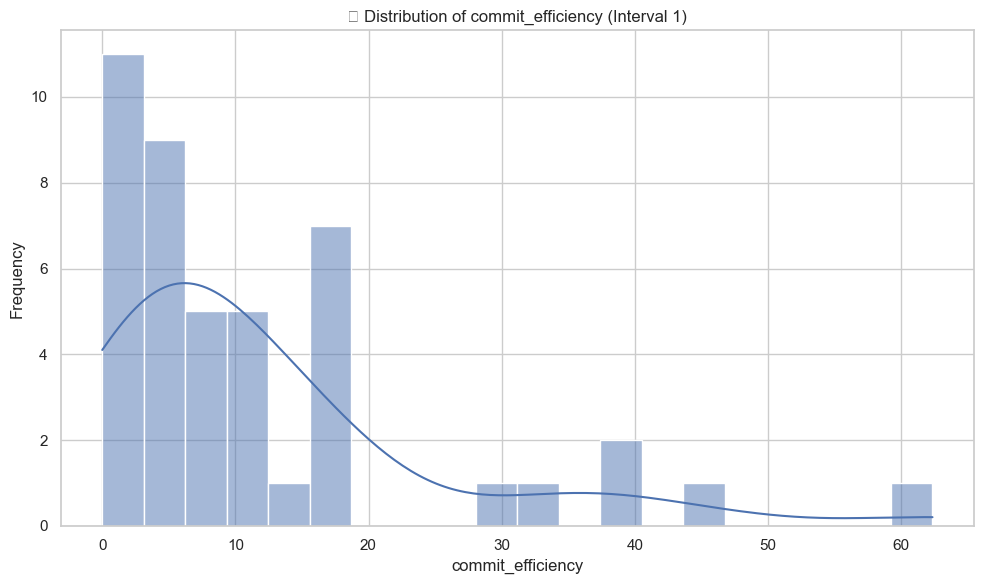

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


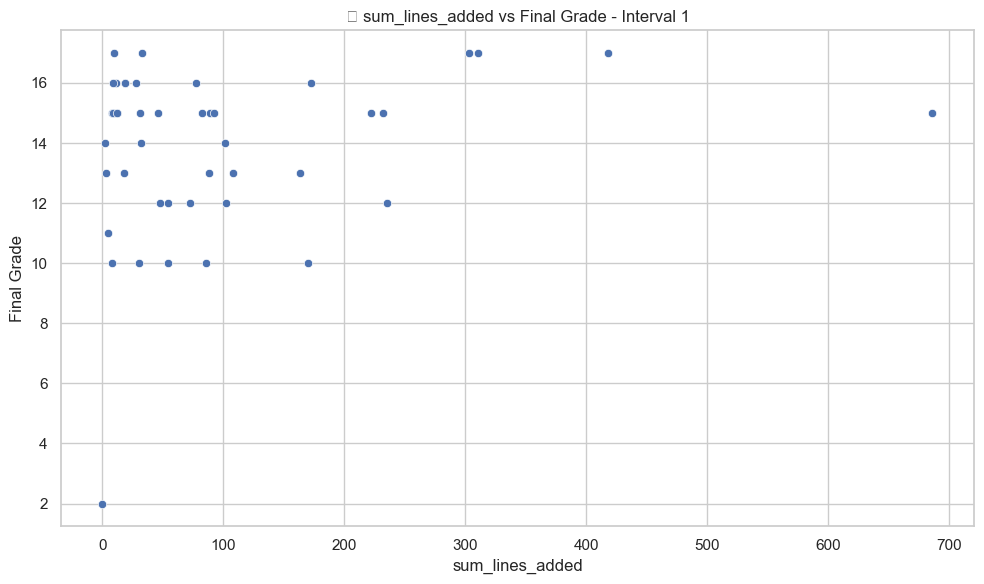

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


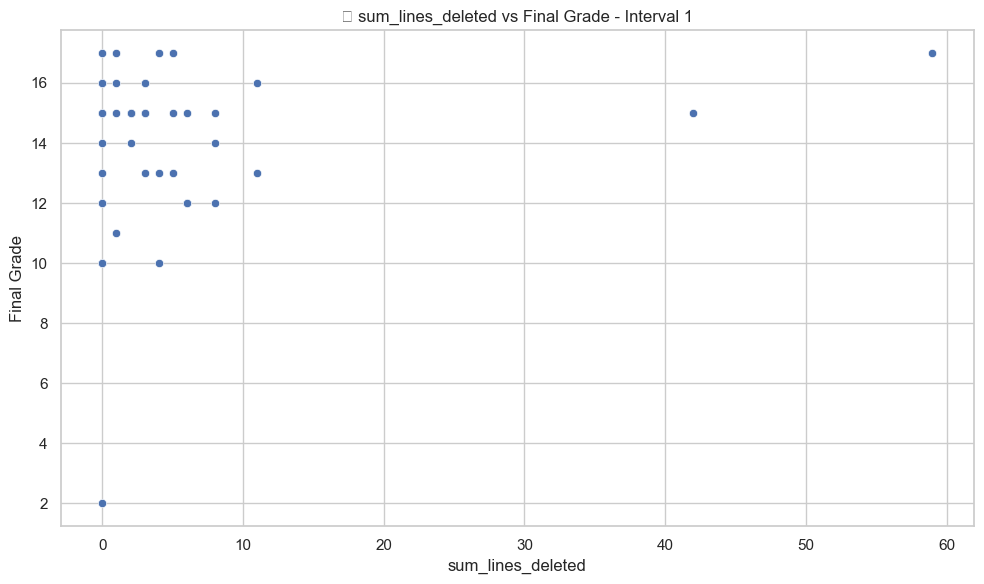

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


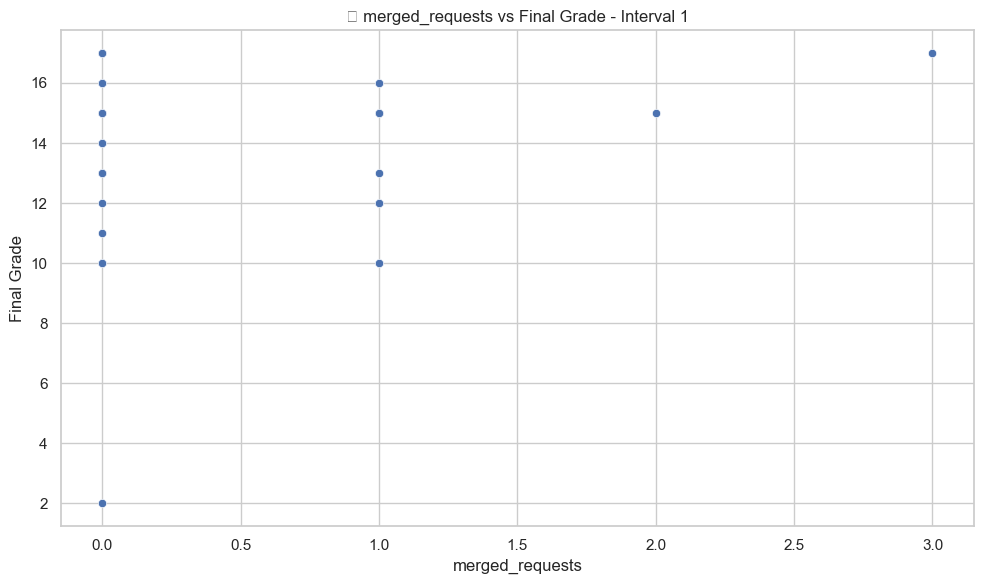

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


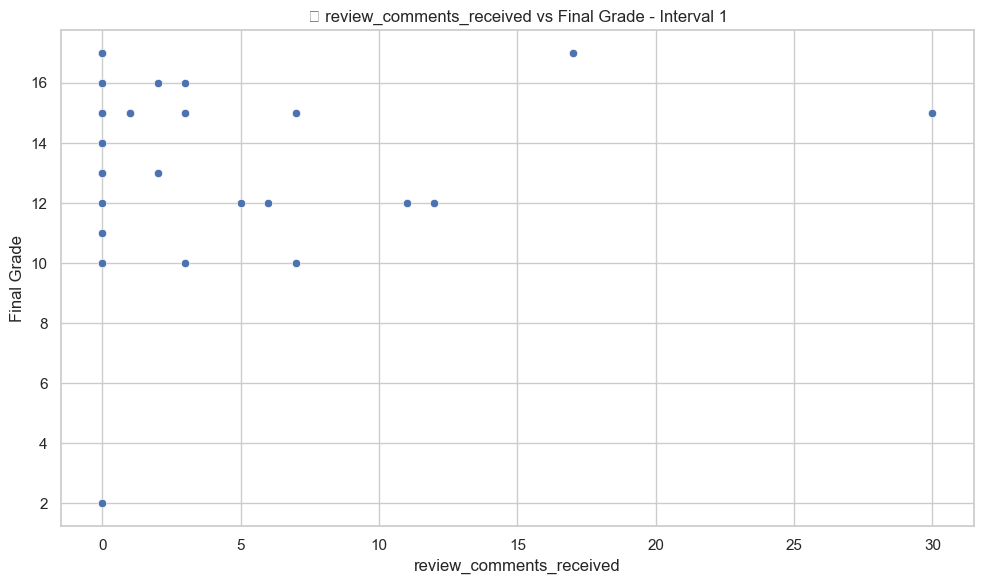

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


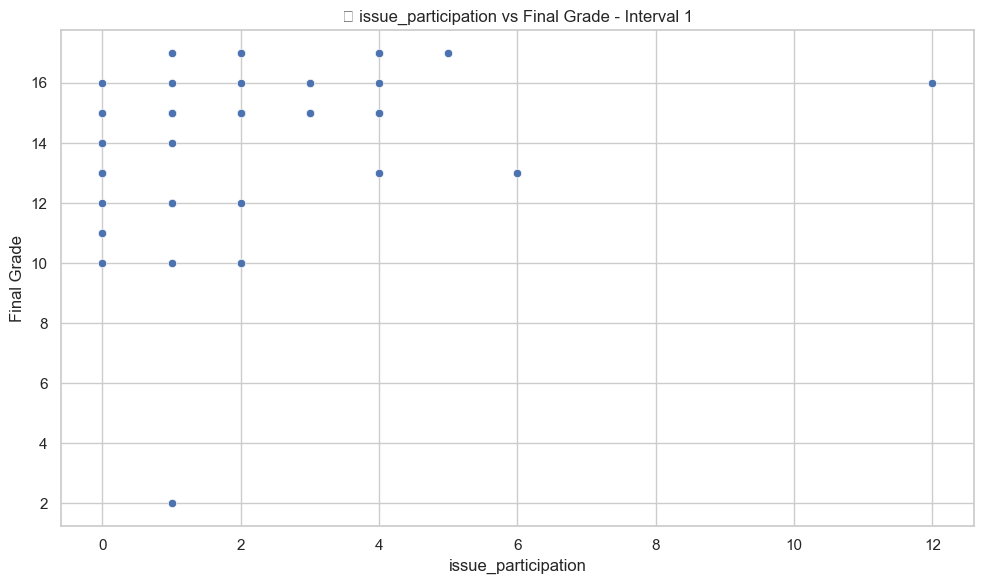

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


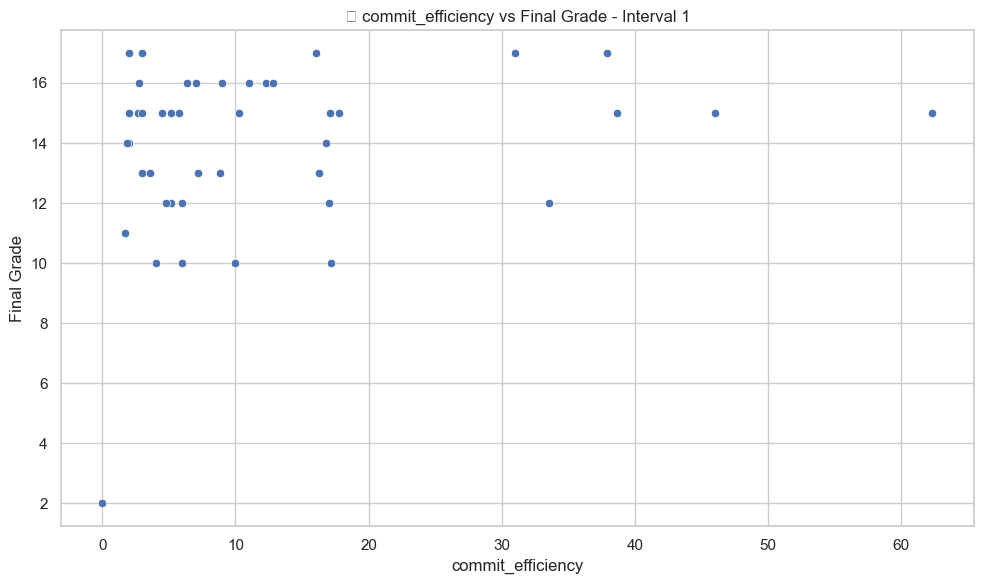

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:124: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


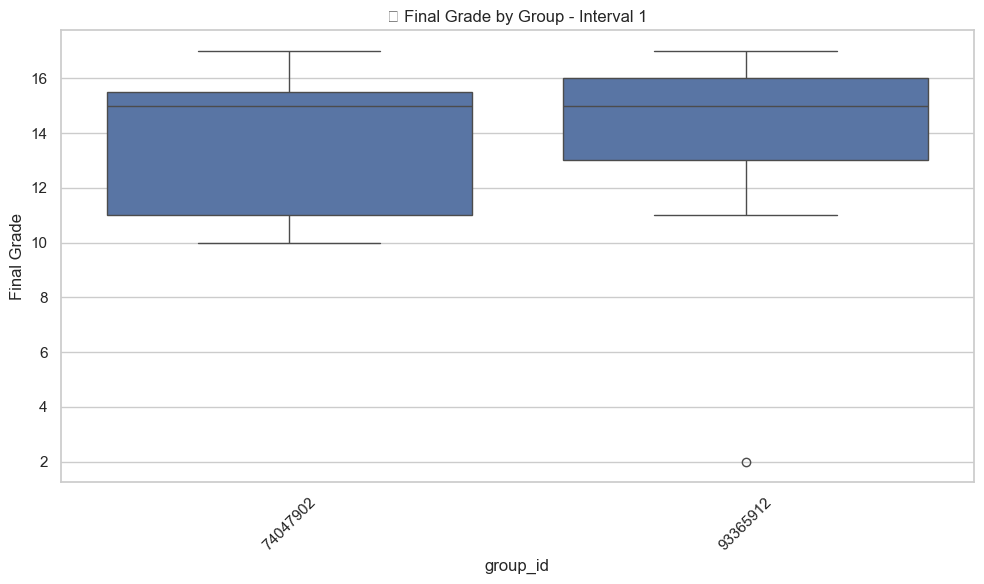

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:56: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()


📁 EDA for Interval 2
🔁 Duplicates found in Interval 2: 0


/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


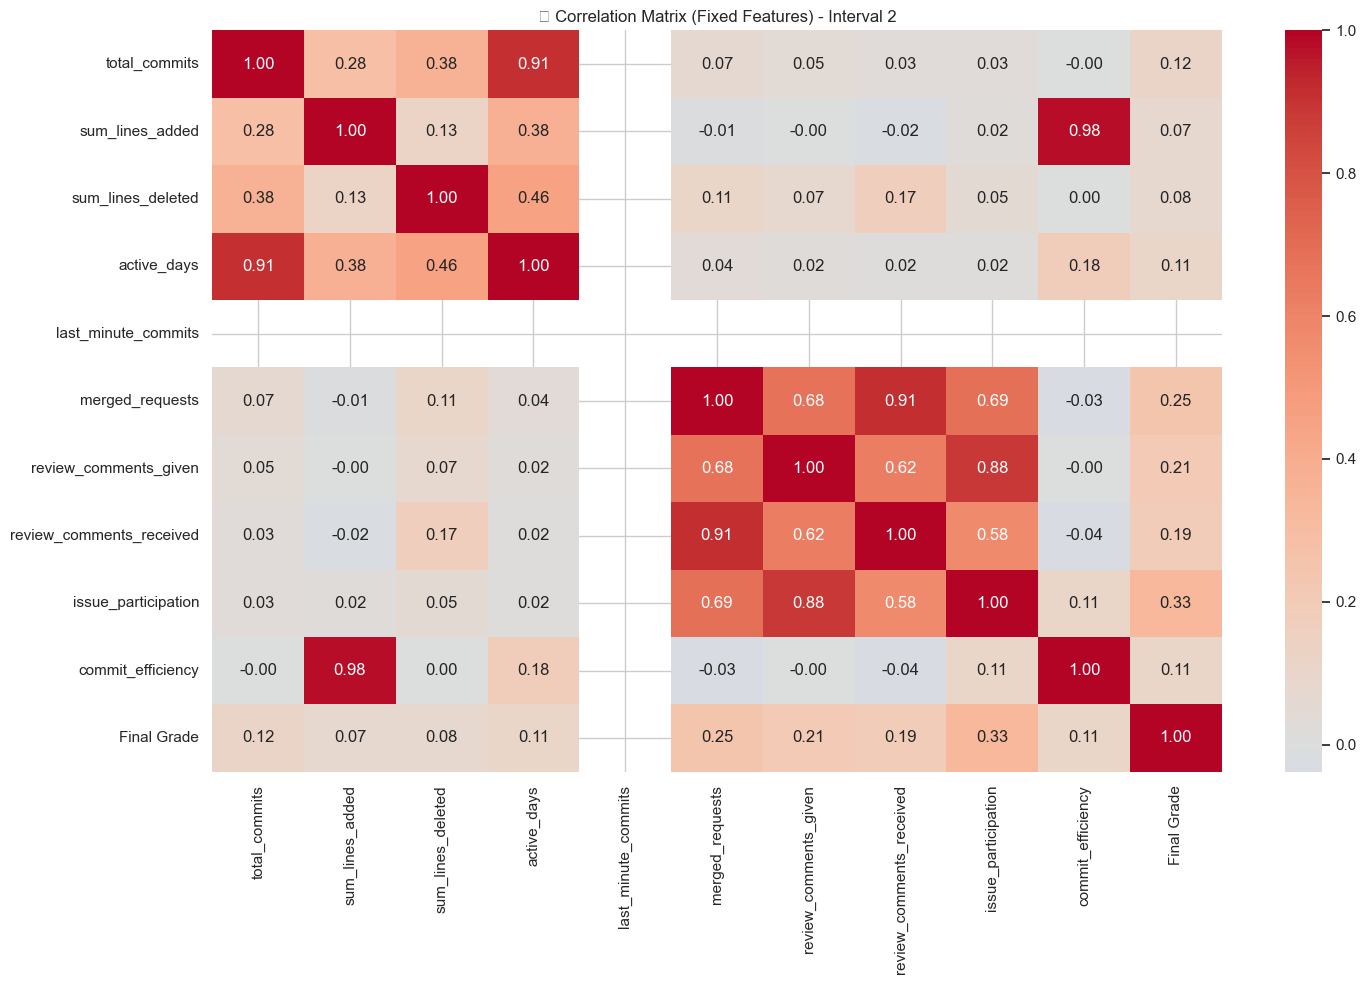

📉 Remoção de outliers (por feature): 53 ➝ 0 linhas
⚠️ Poucos dados após limpeza no Intervalo 2, a usar o dataset original sem remover outliers.


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


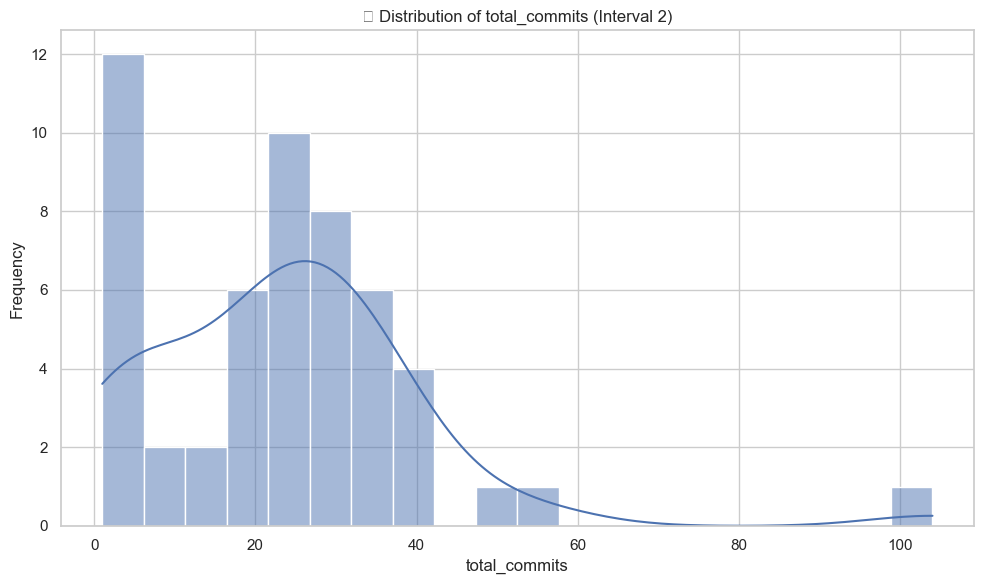

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


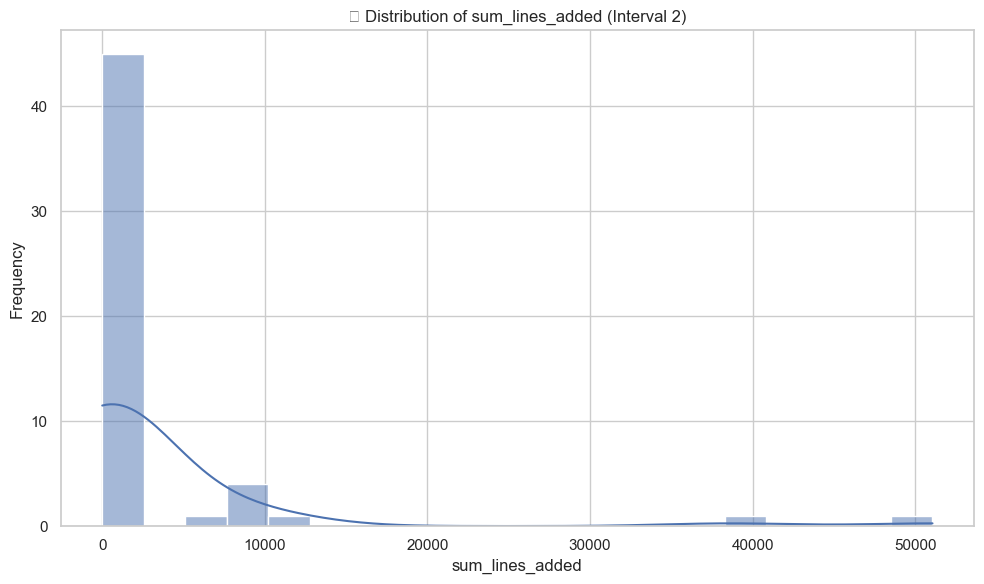

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


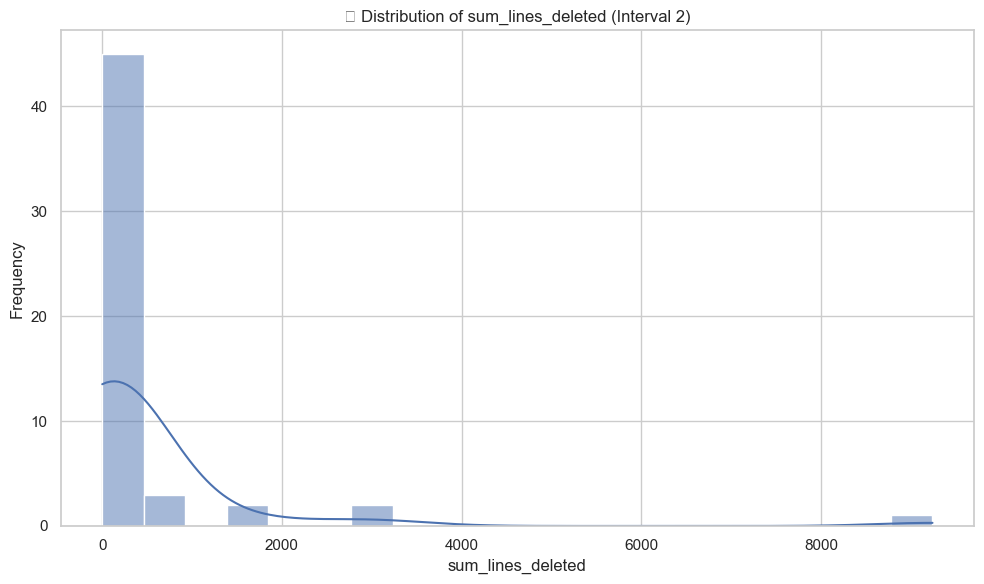

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


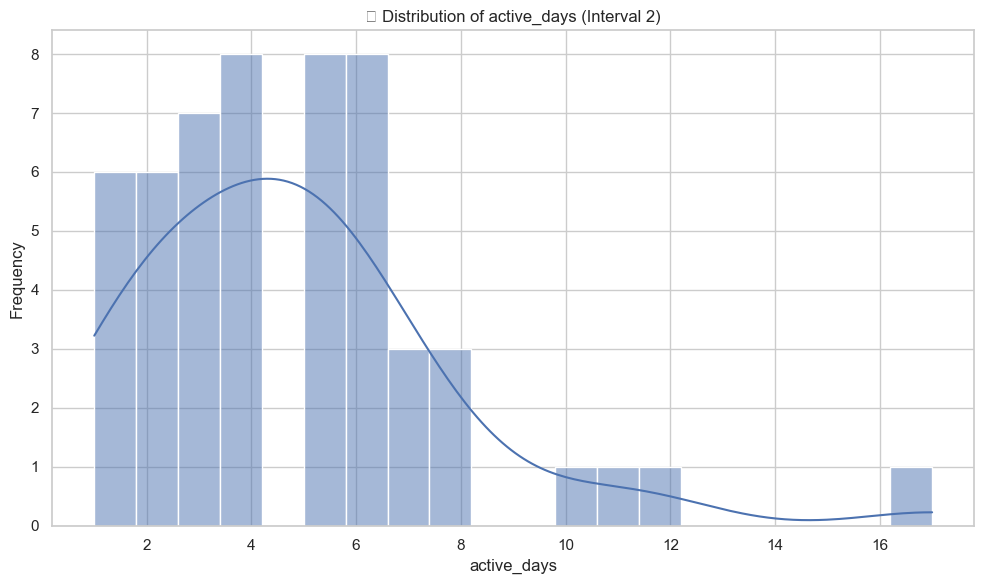

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


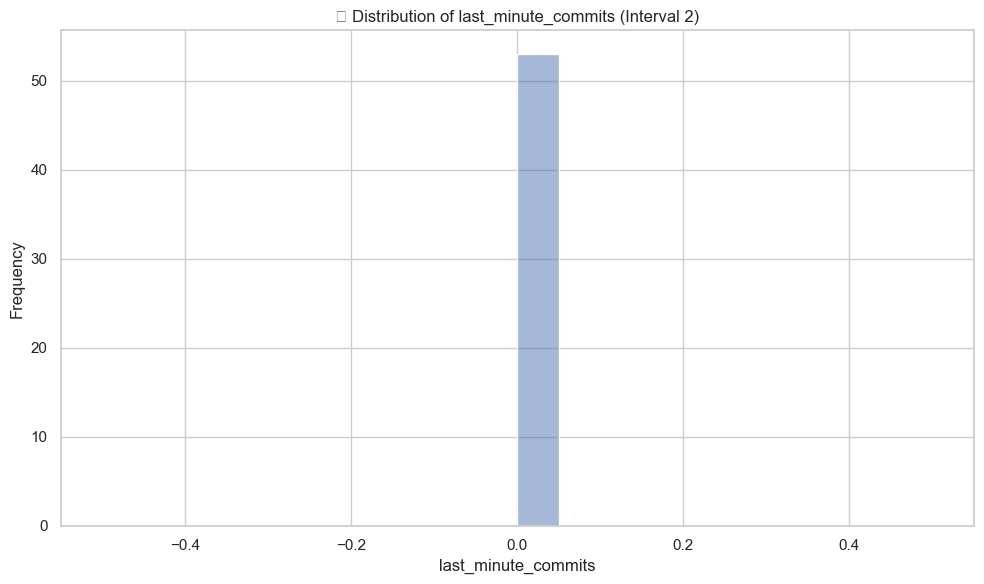

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


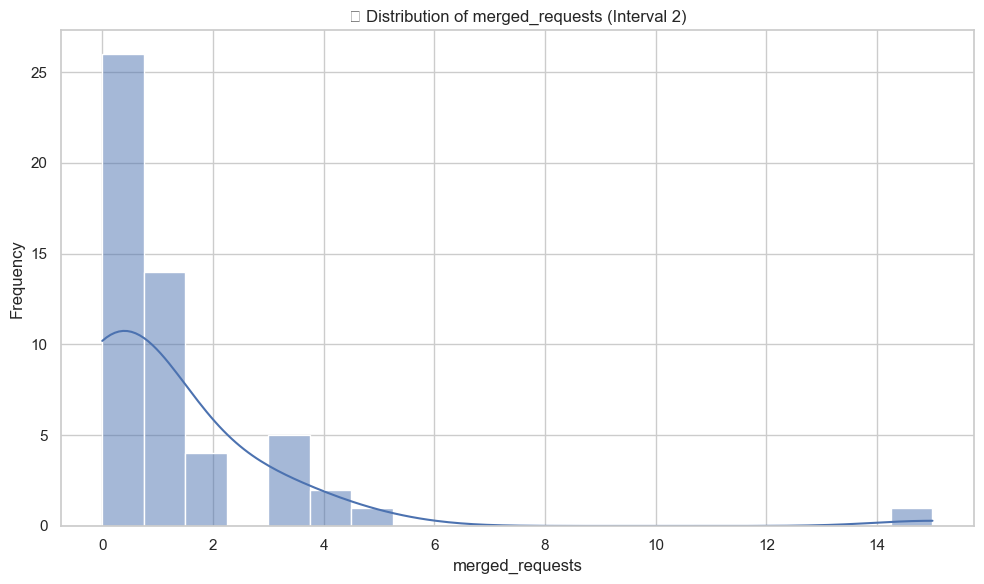

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


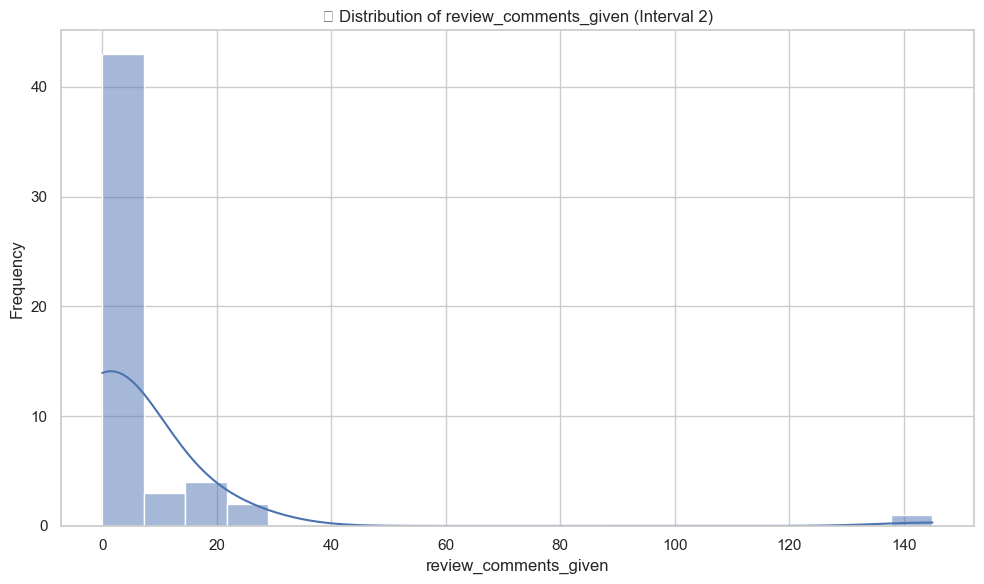

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


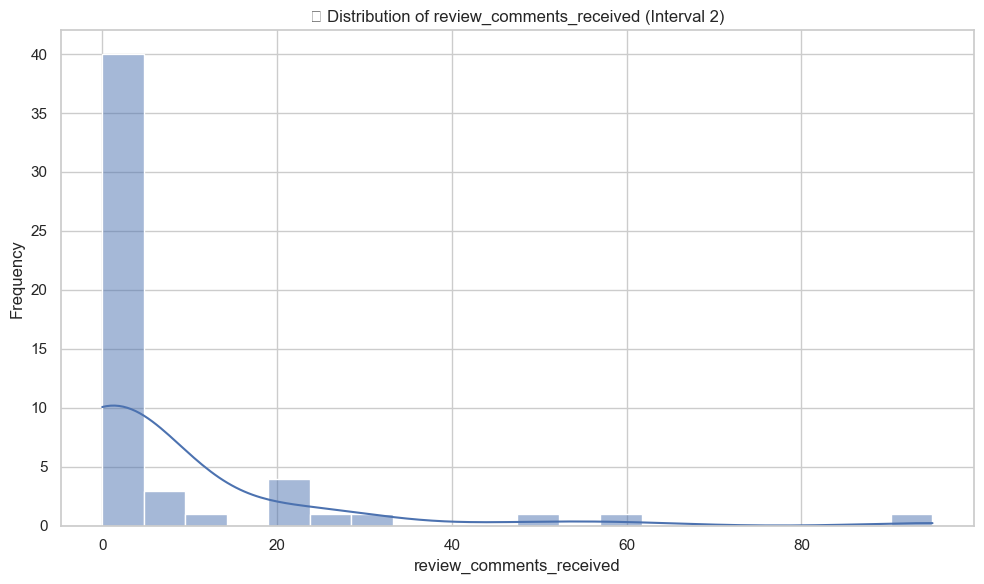

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


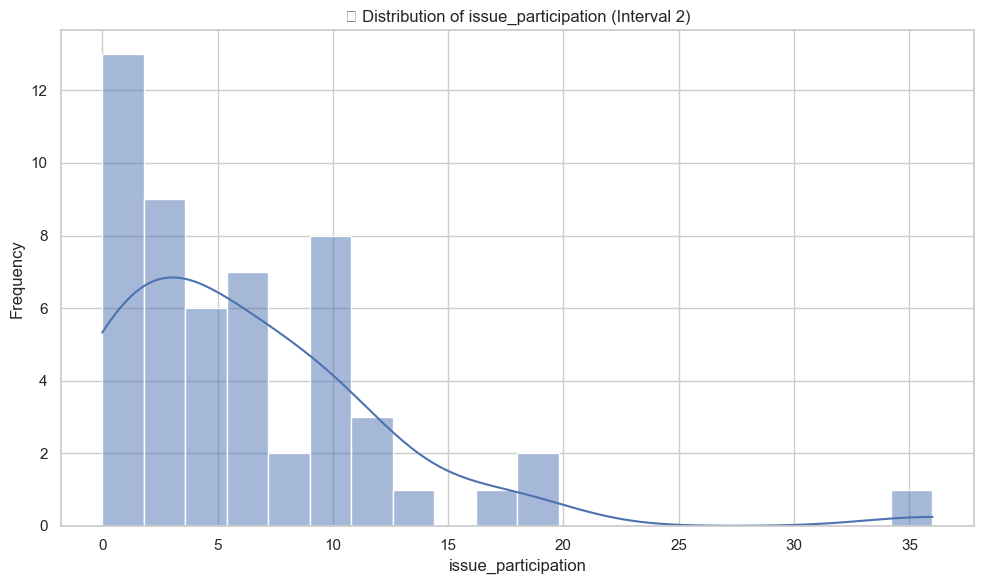

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


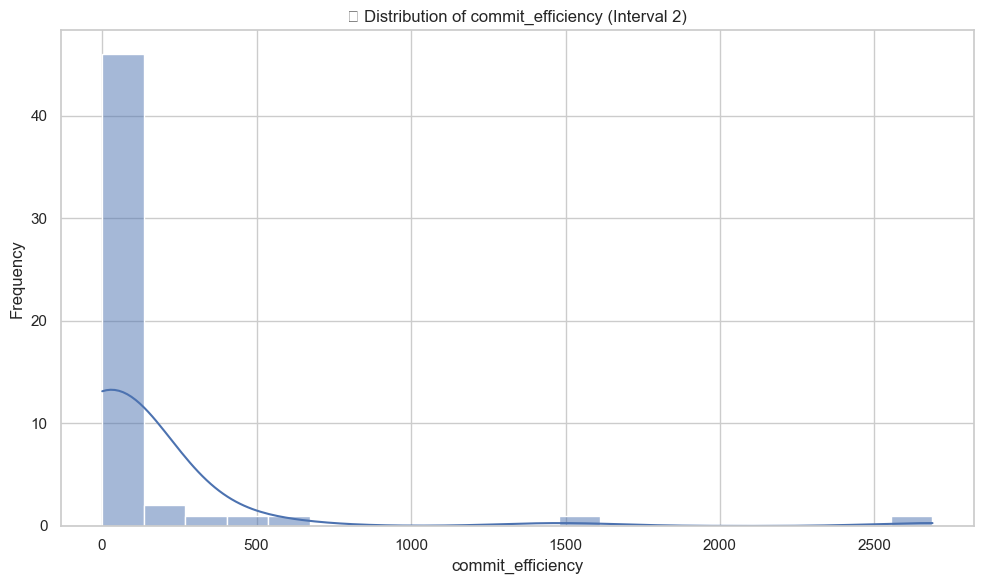

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


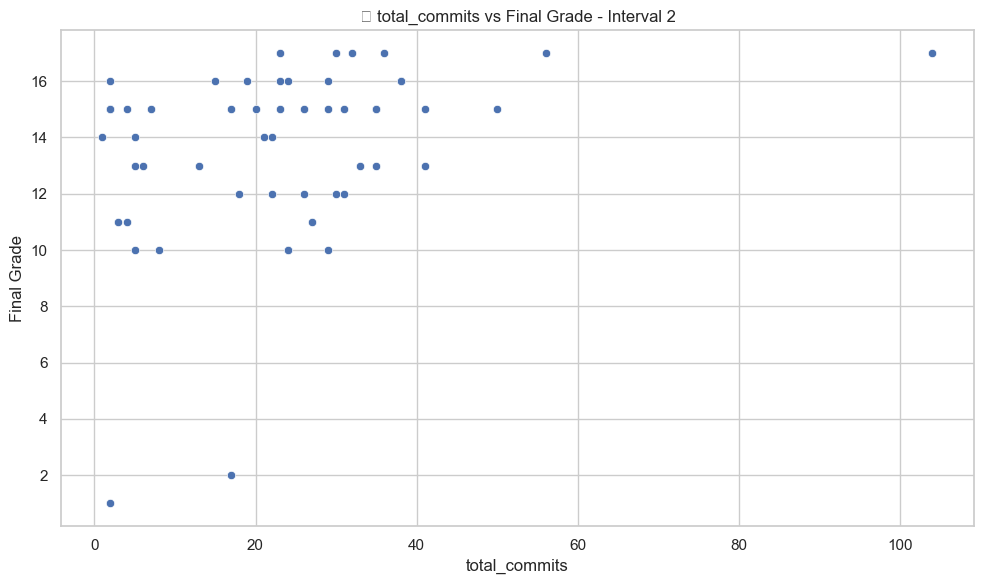

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


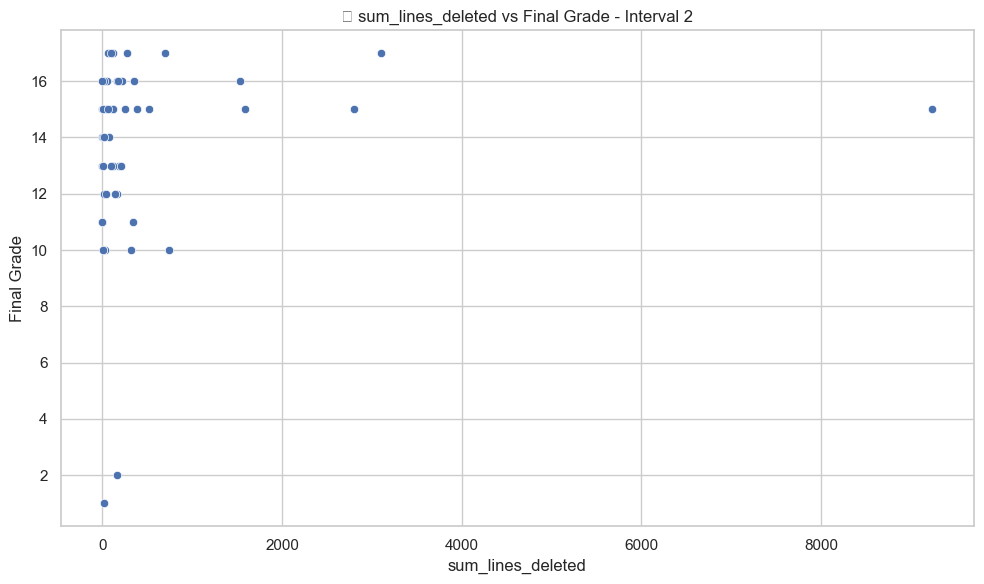

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


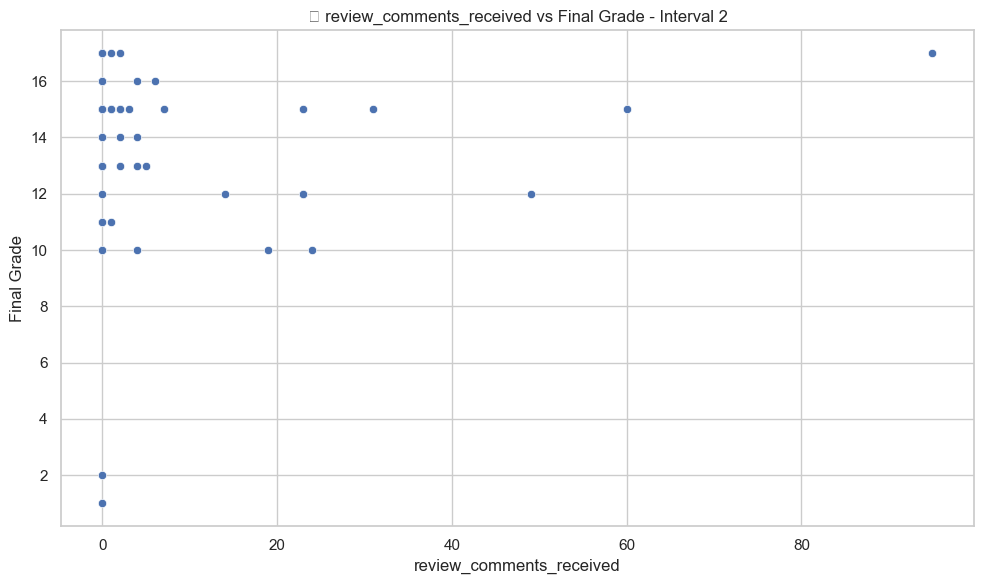

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


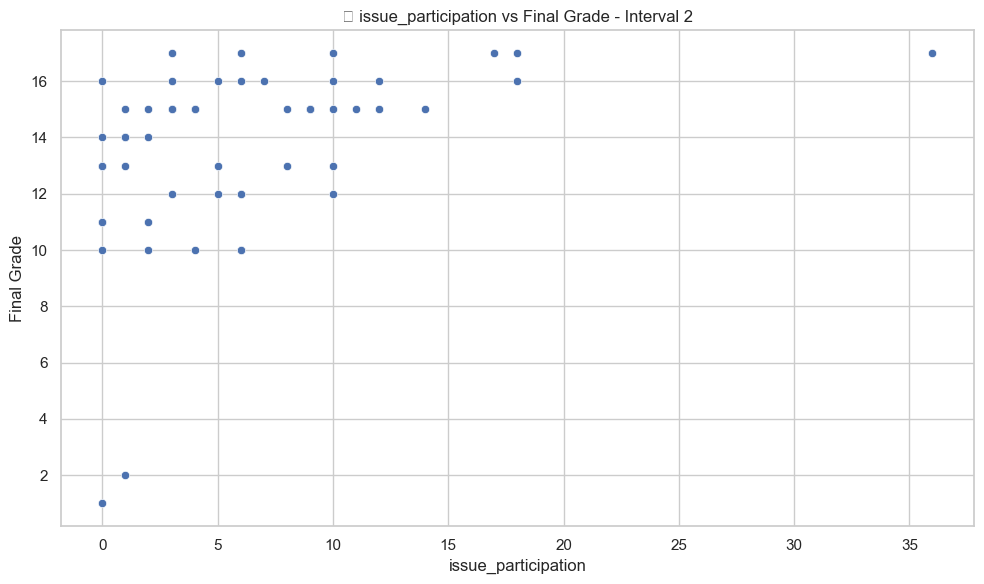

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


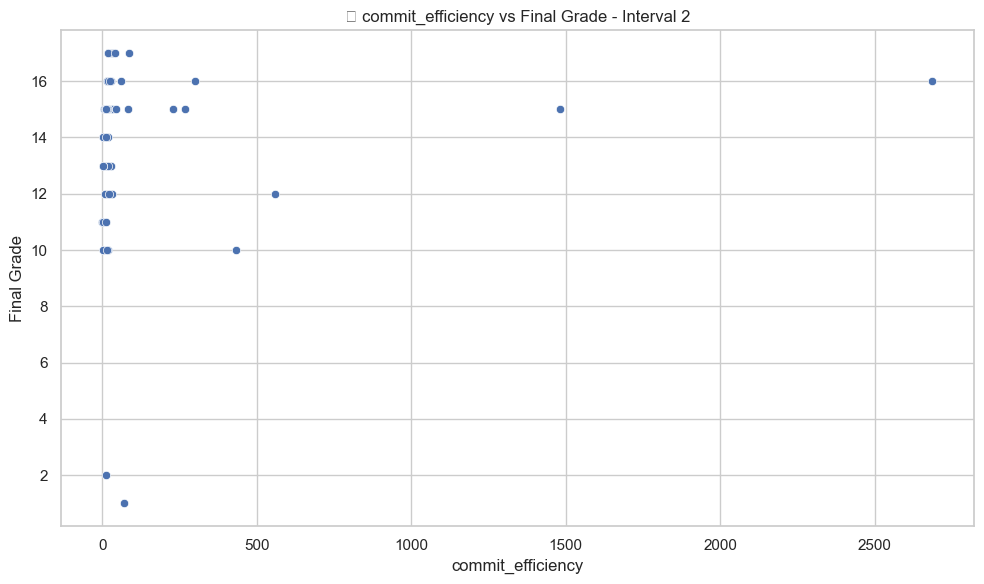

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:124: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


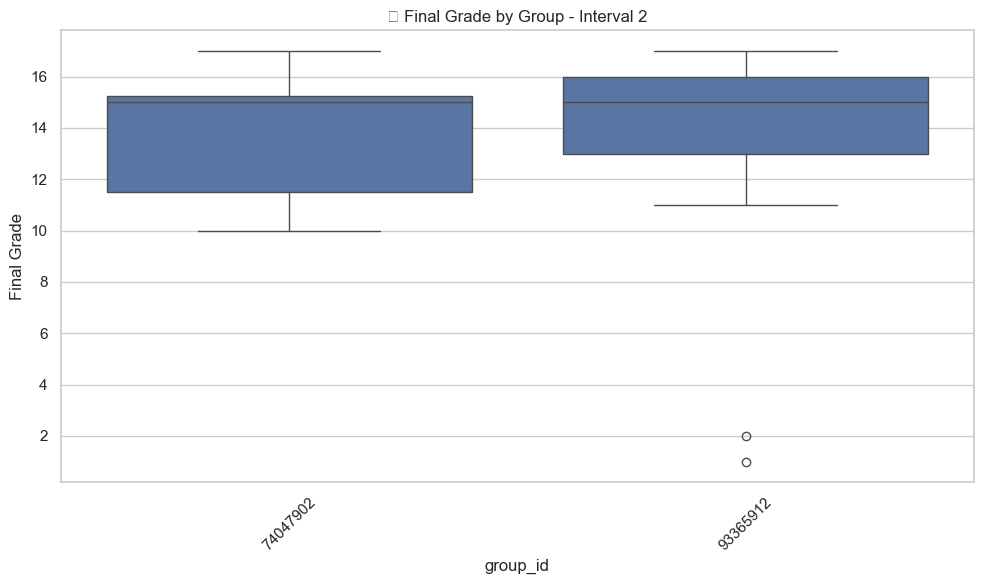

📁 EDA for Interval 3
🔁 Duplicates found in Interval 3: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:56: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


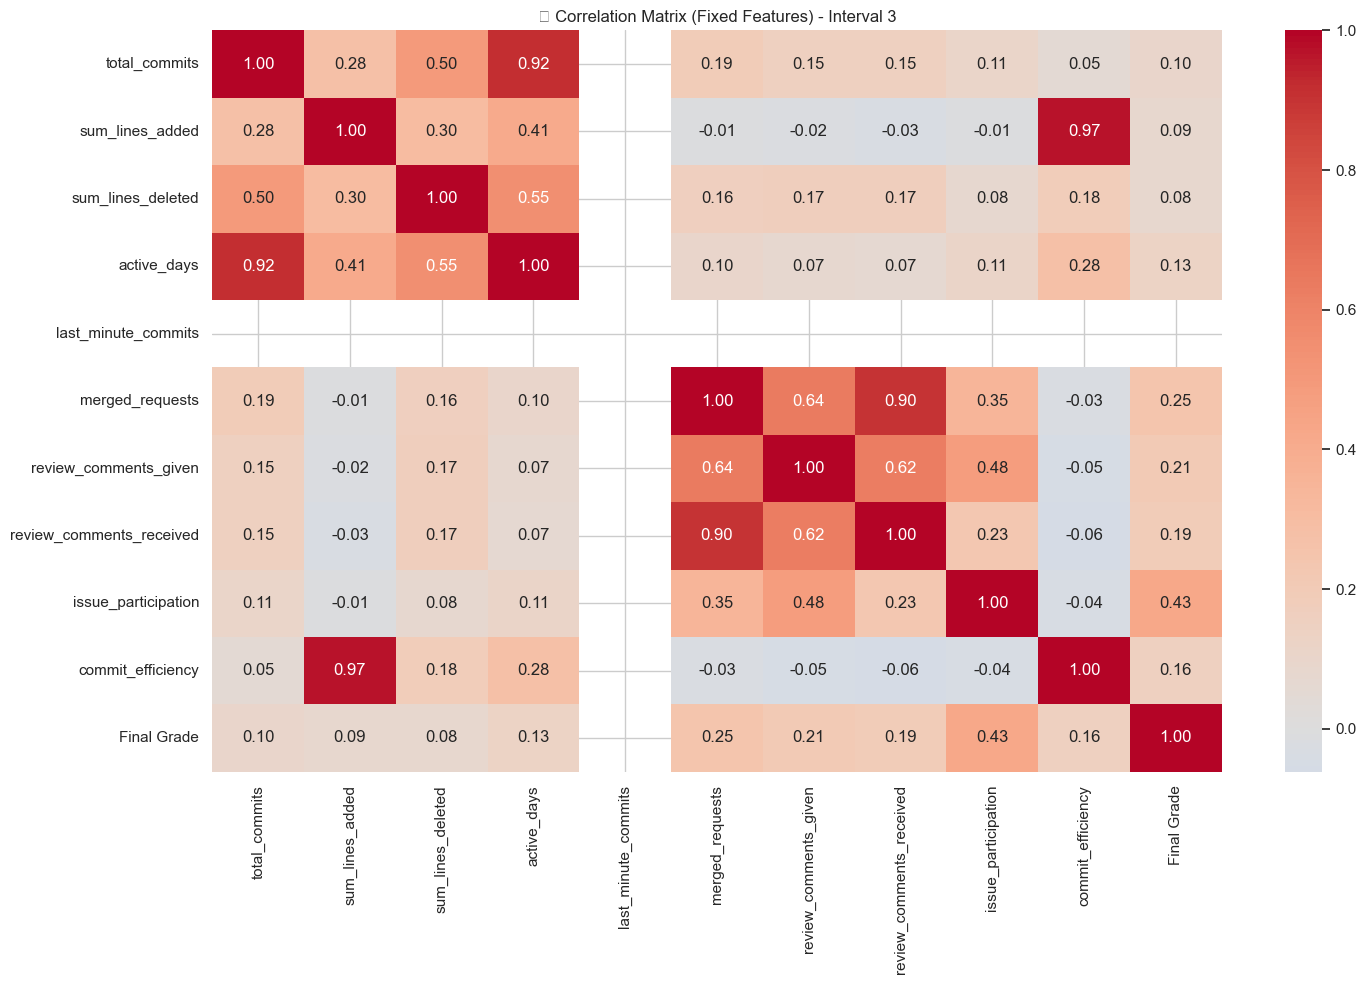

📉 Remoção de outliers (por feature): 57 ➝ 0 linhas
⚠️ Poucos dados após limpeza no Intervalo 3, a usar o dataset original sem remover outliers.


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


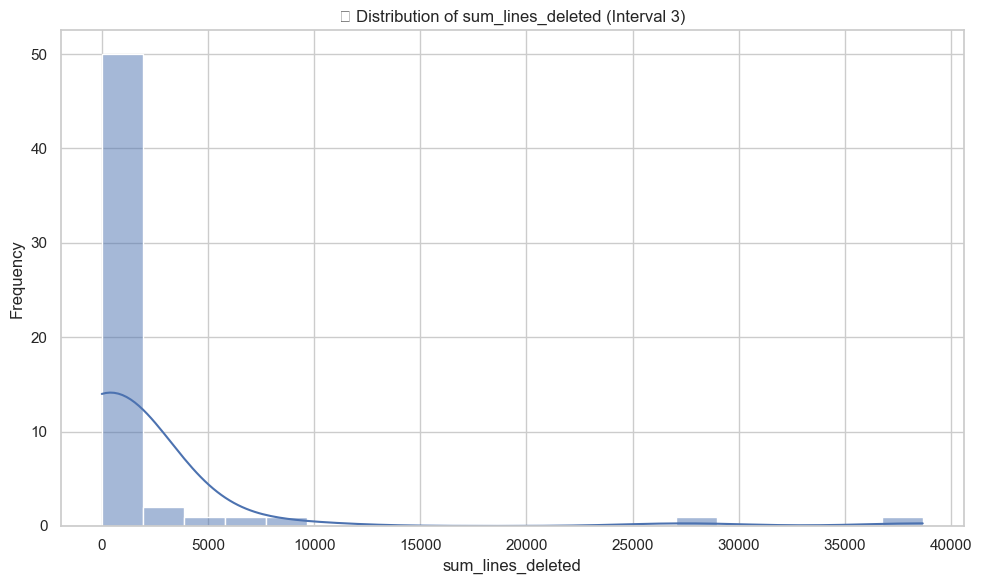

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


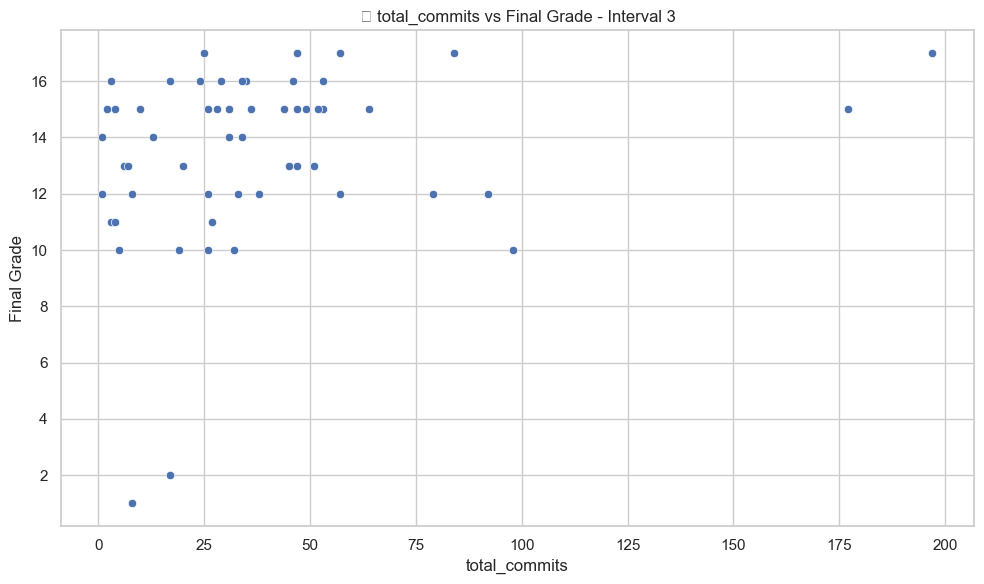

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


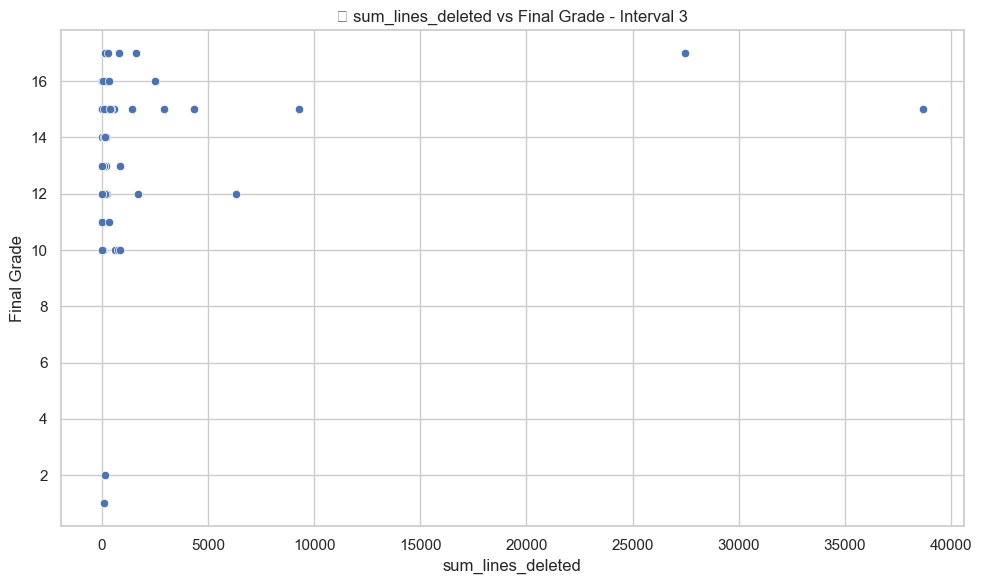

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


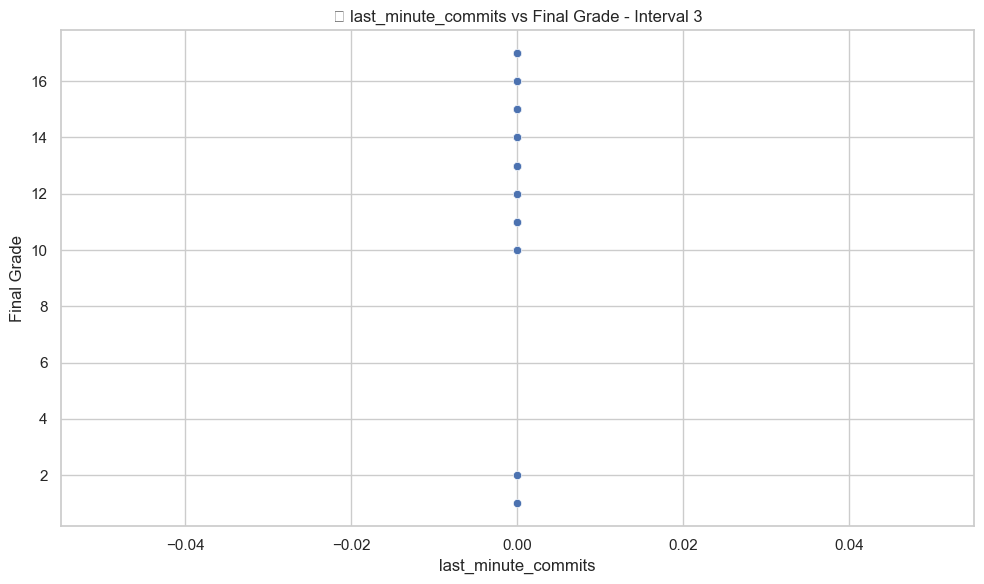

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


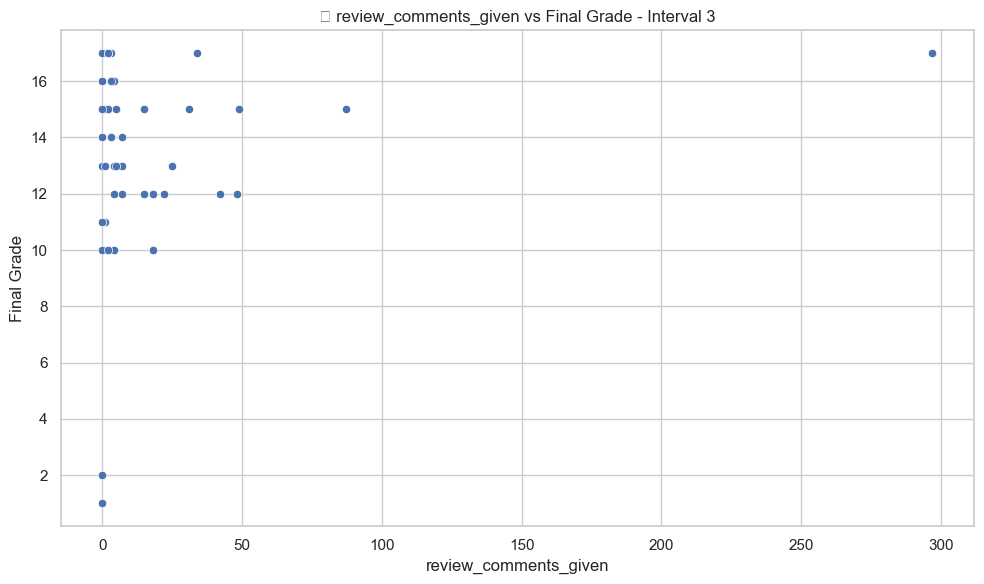

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:124: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


📁 EDA for Interval 4
🔁 Duplicates found in Interval 4: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:56: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


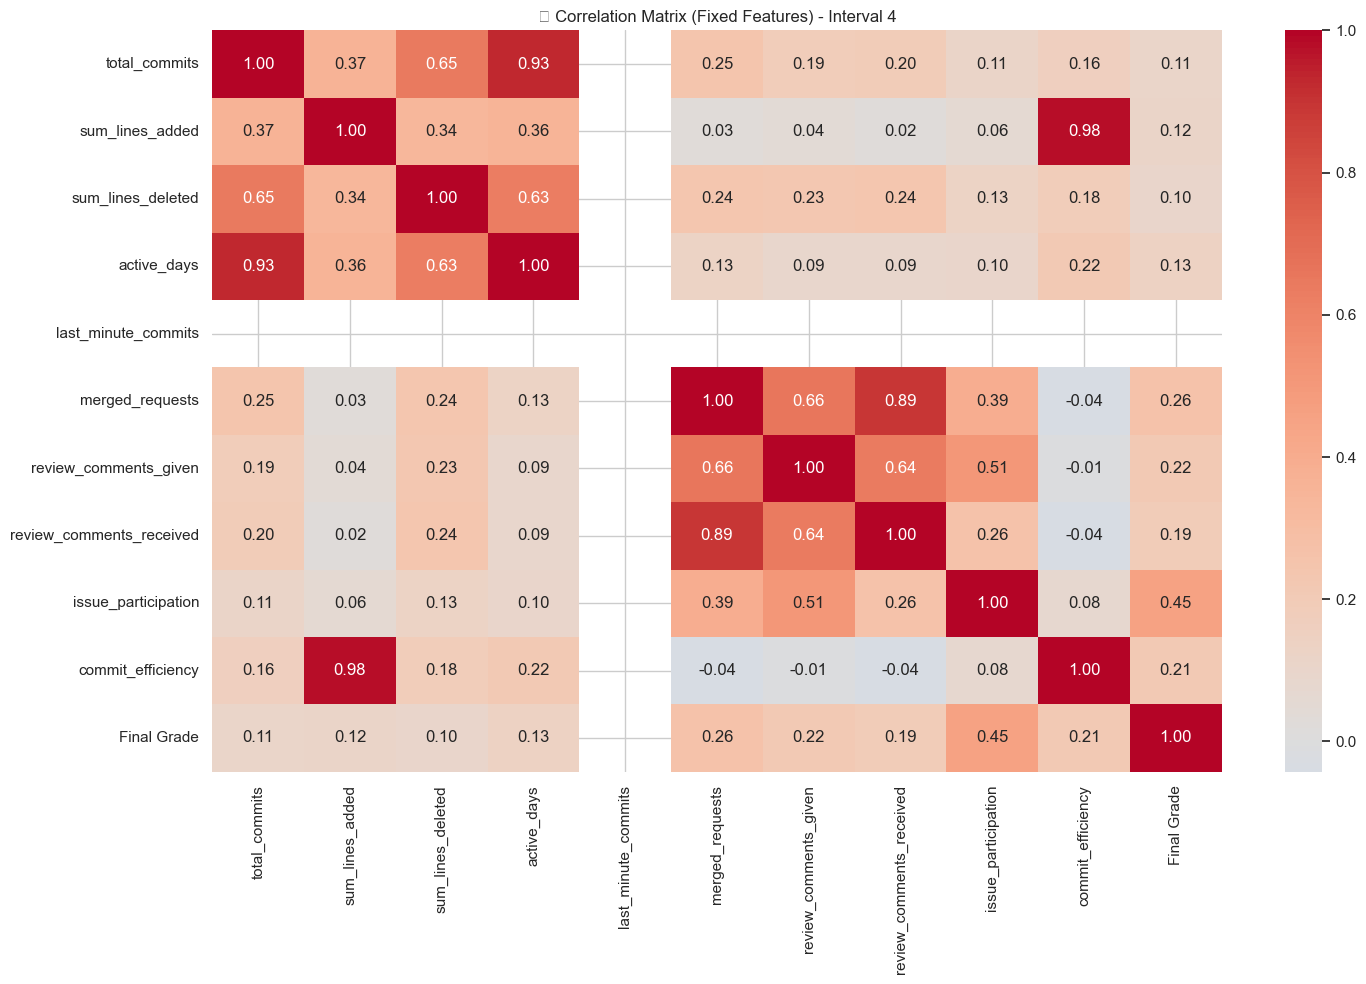

📉 Remoção de outliers (por feature): 59 ➝ 0 linhas
⚠️ Poucos dados após limpeza no Intervalo 4, a usar o dataset original sem remover outliers.


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


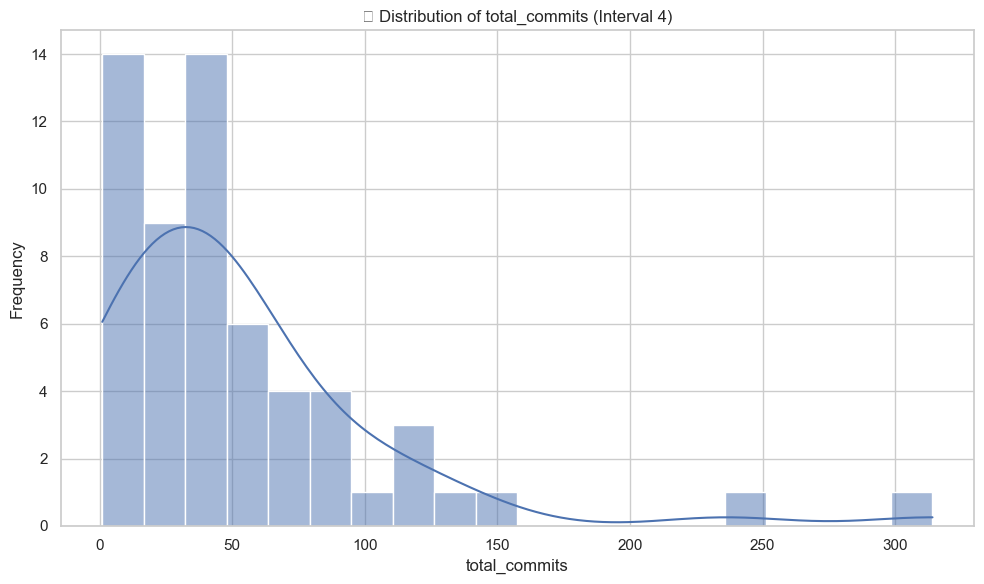

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


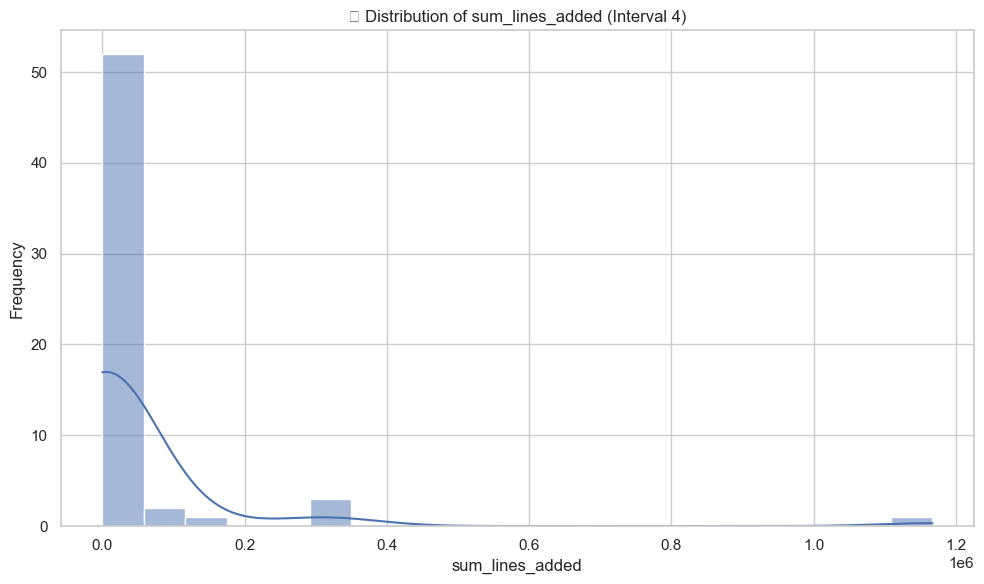

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


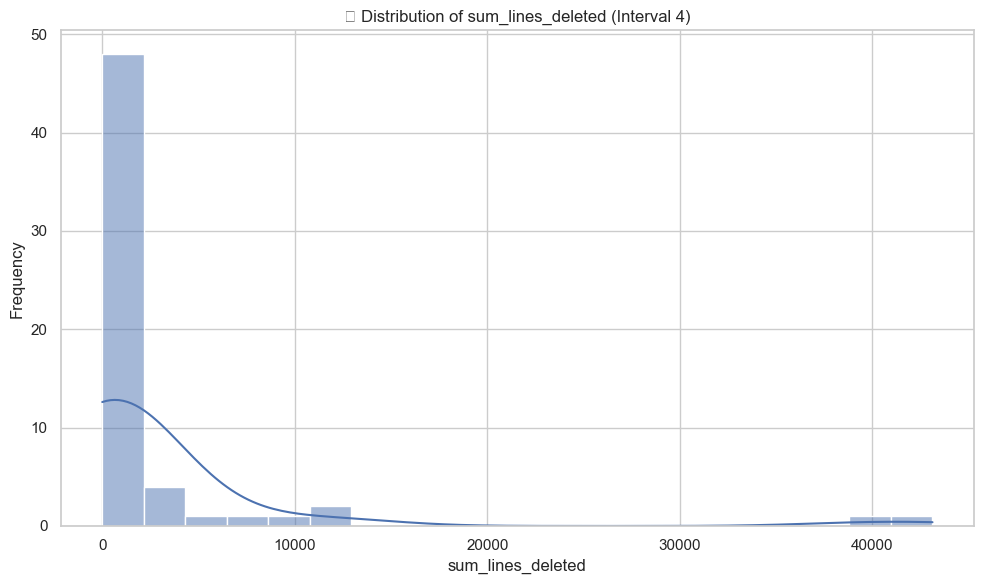

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


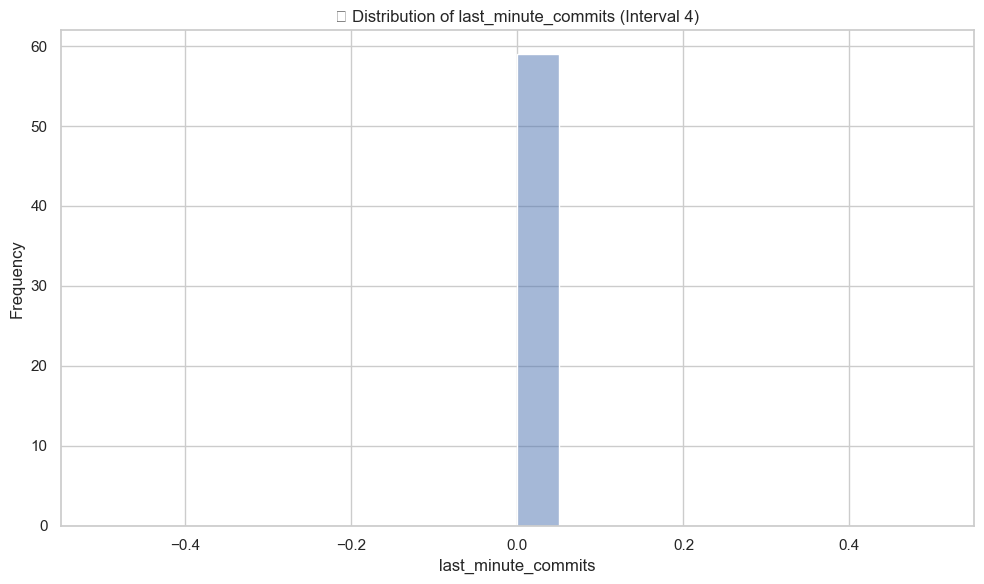

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


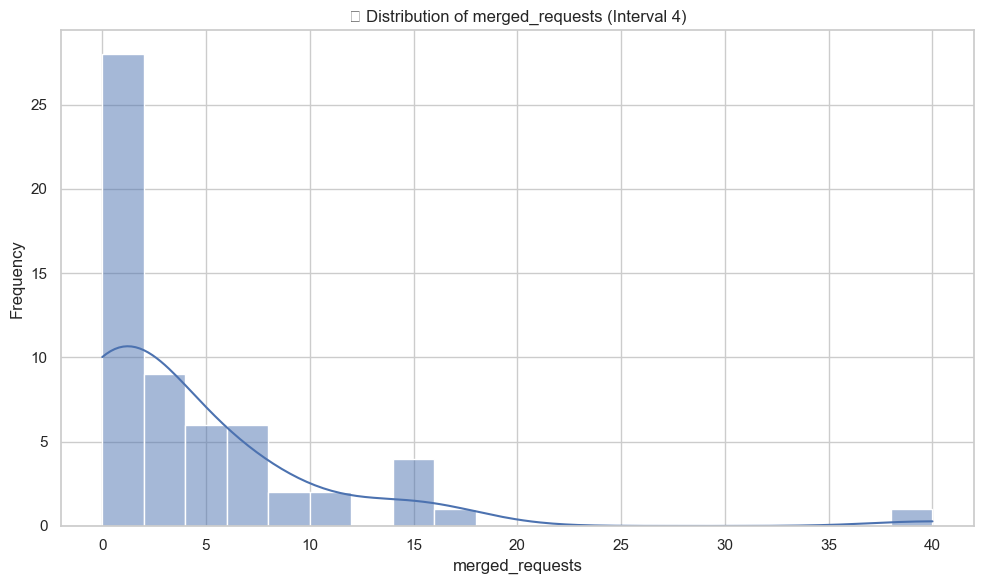

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


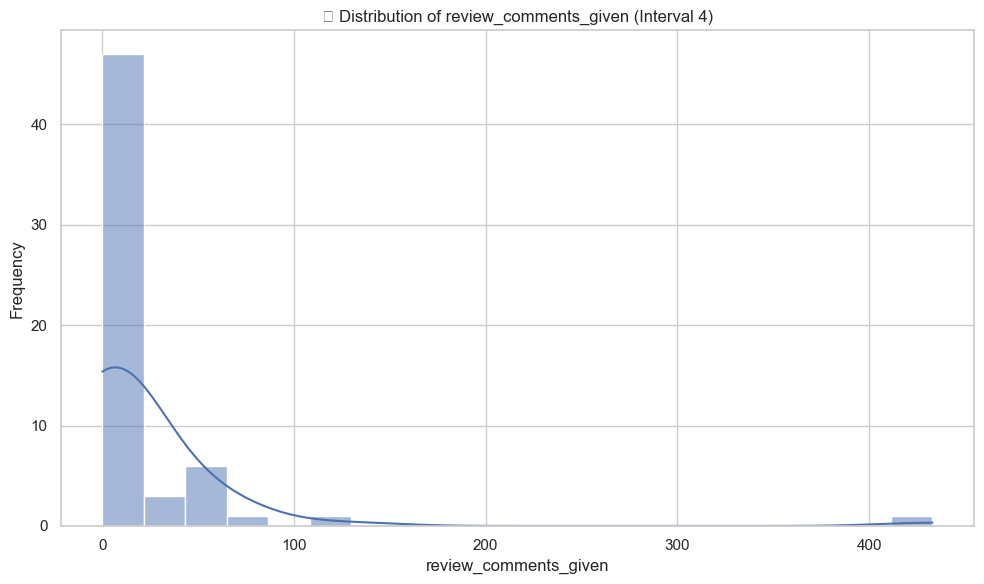

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


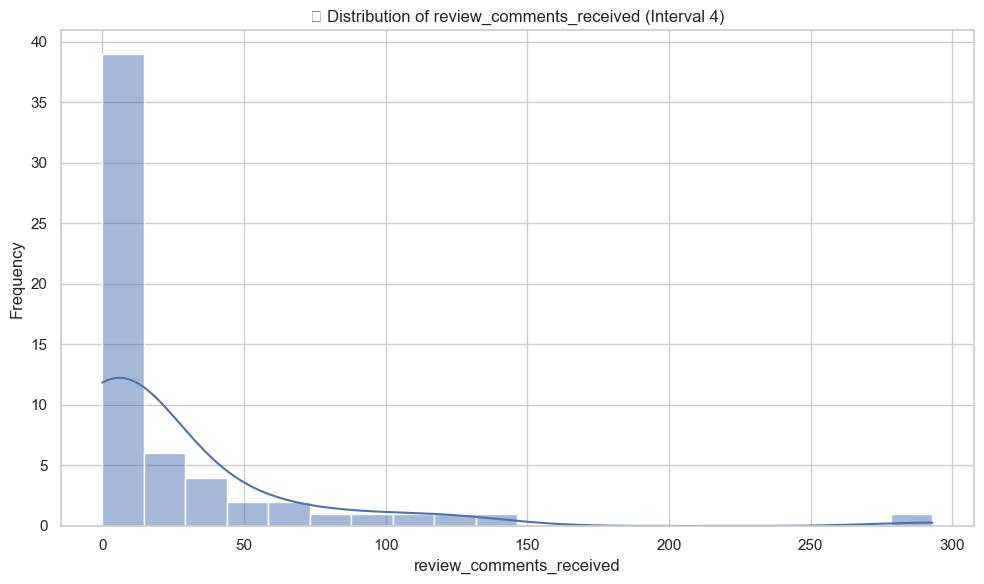

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


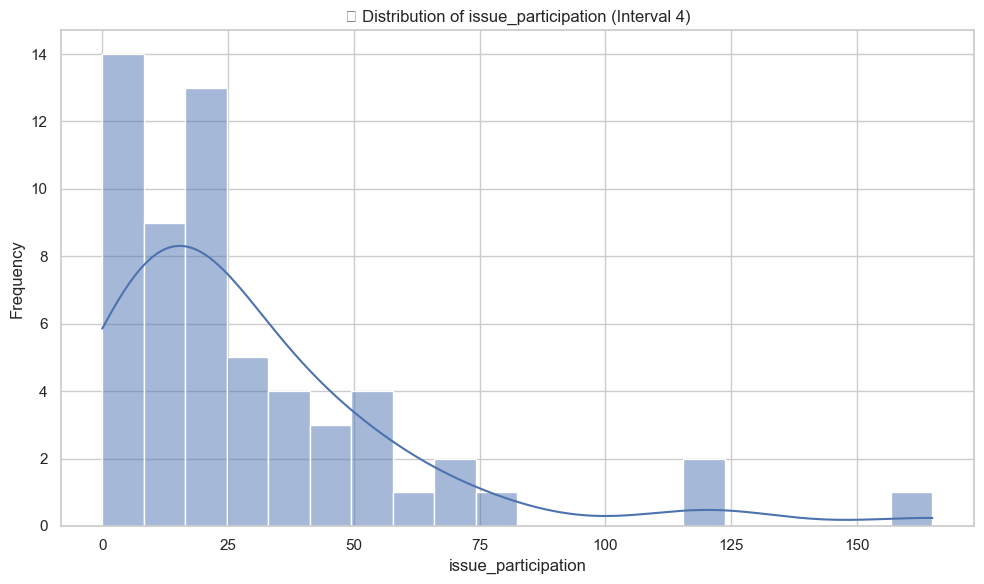

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


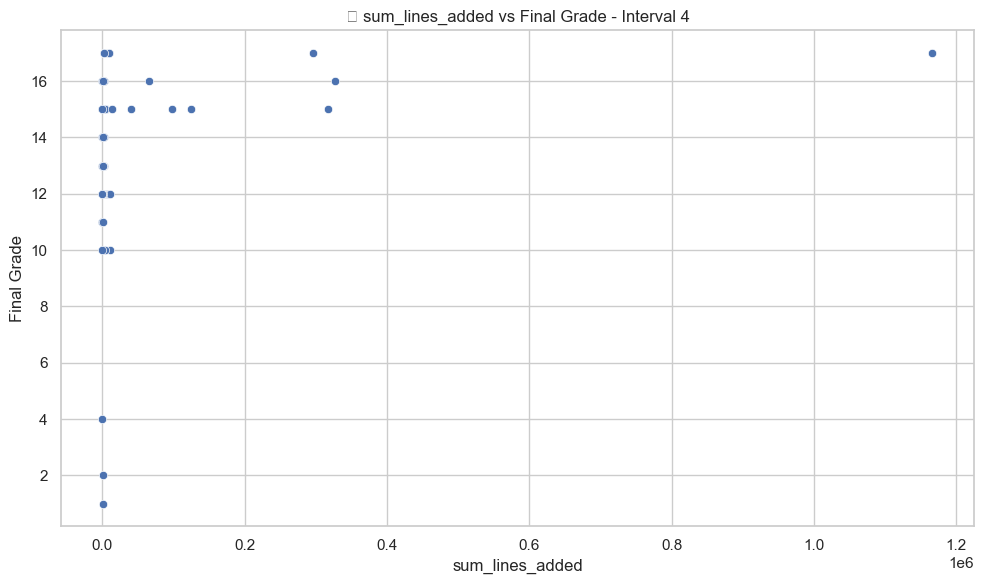

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


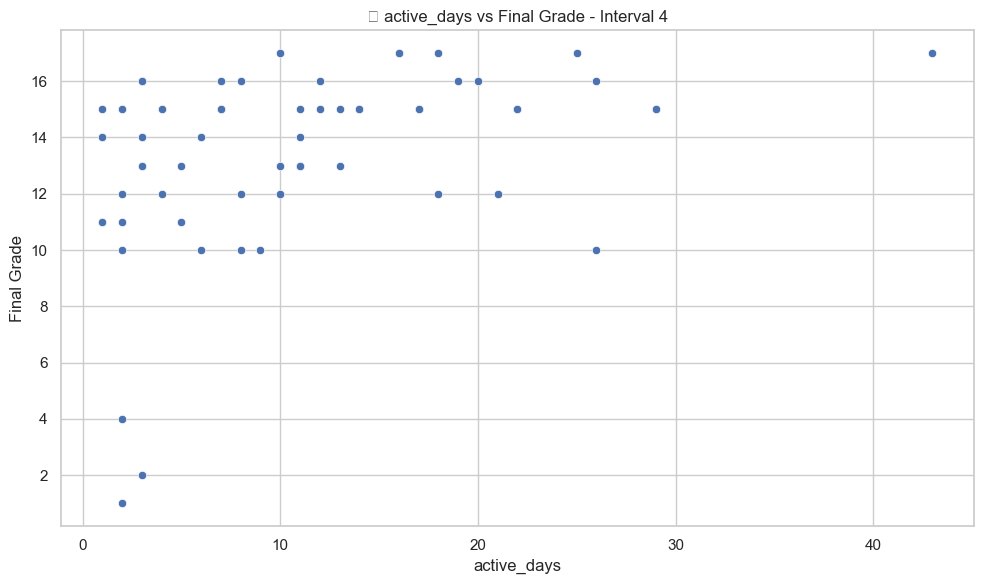

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


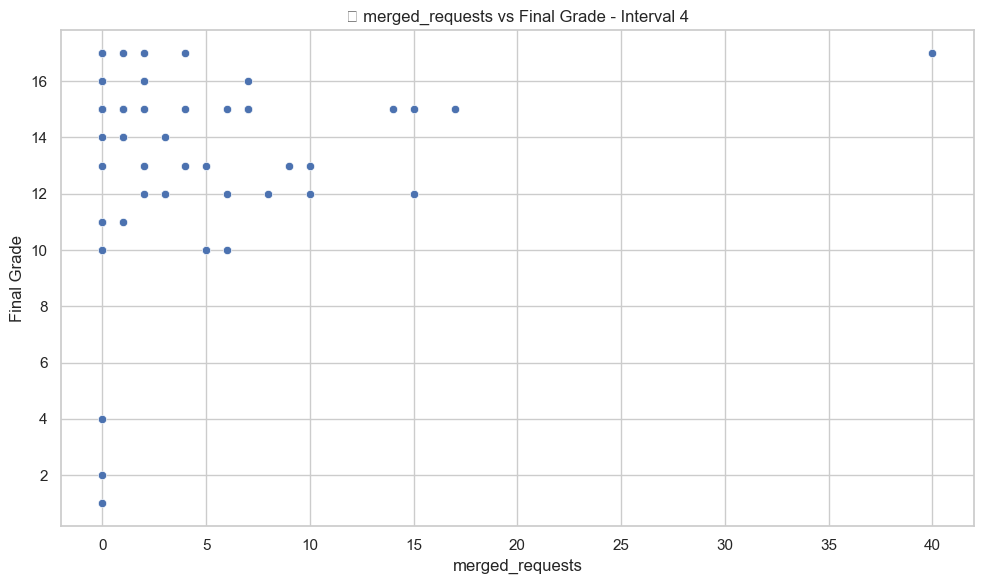

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


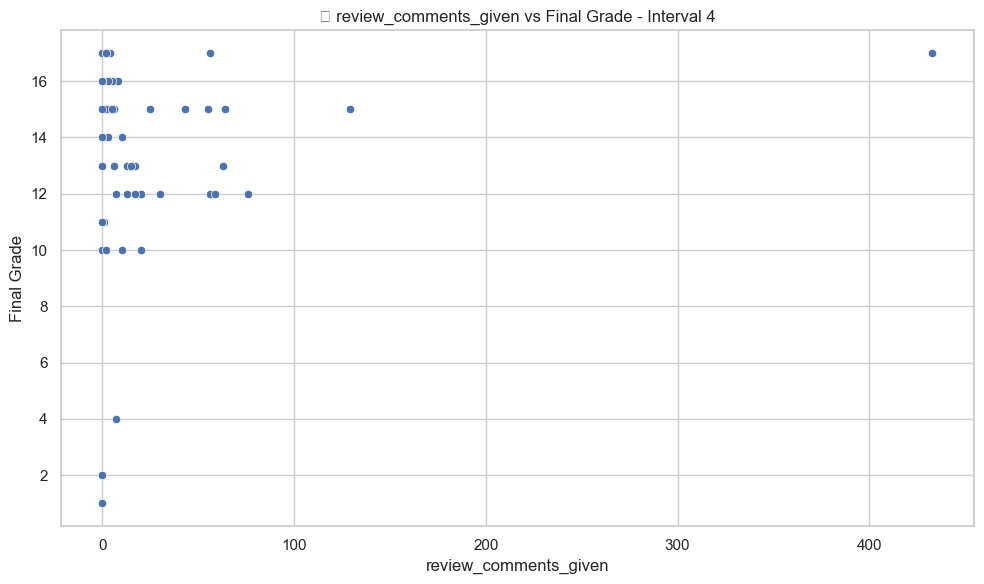

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


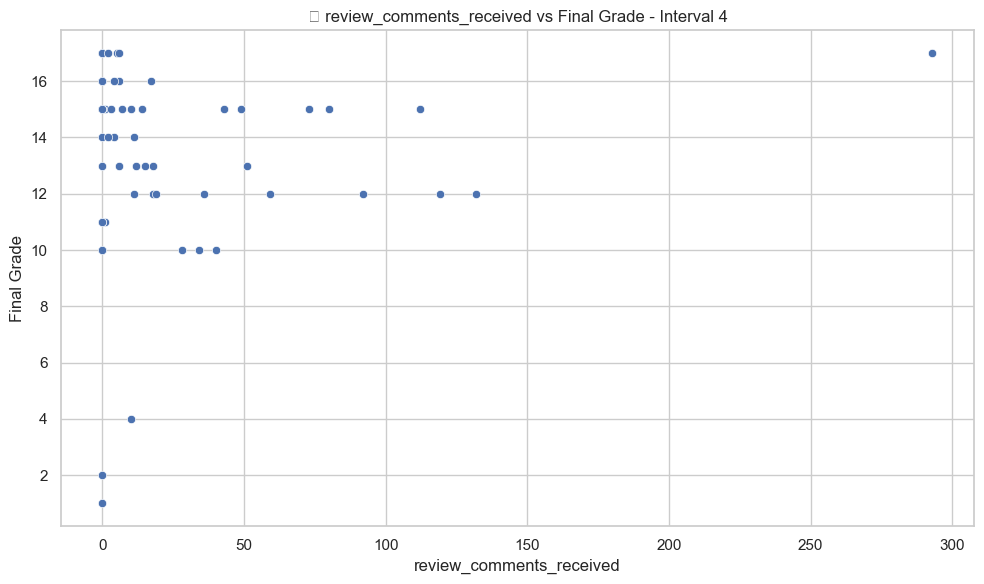

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


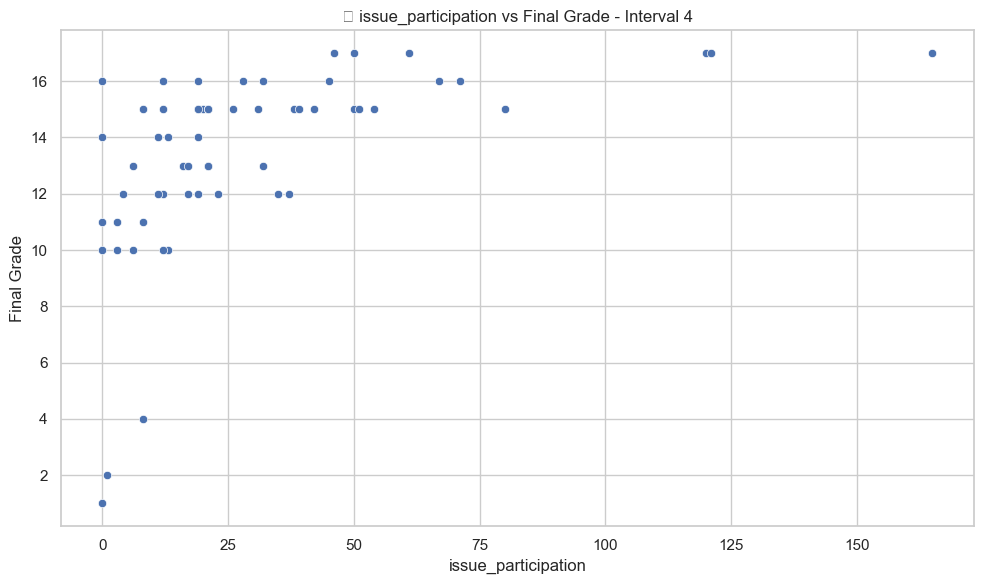

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:124: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


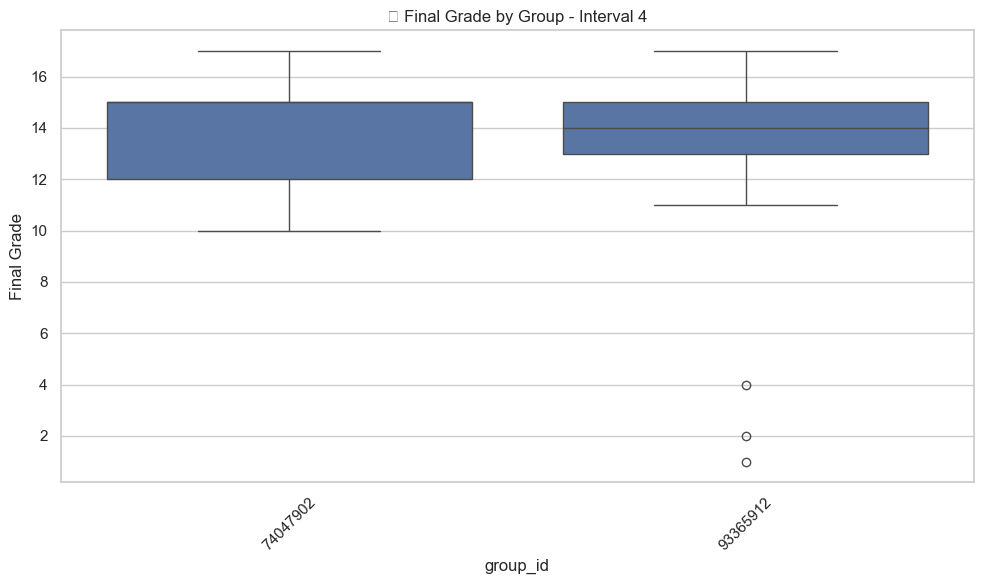

📁 EDA for Interval 5
🔁 Duplicates found in Interval 5: 0


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:56: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


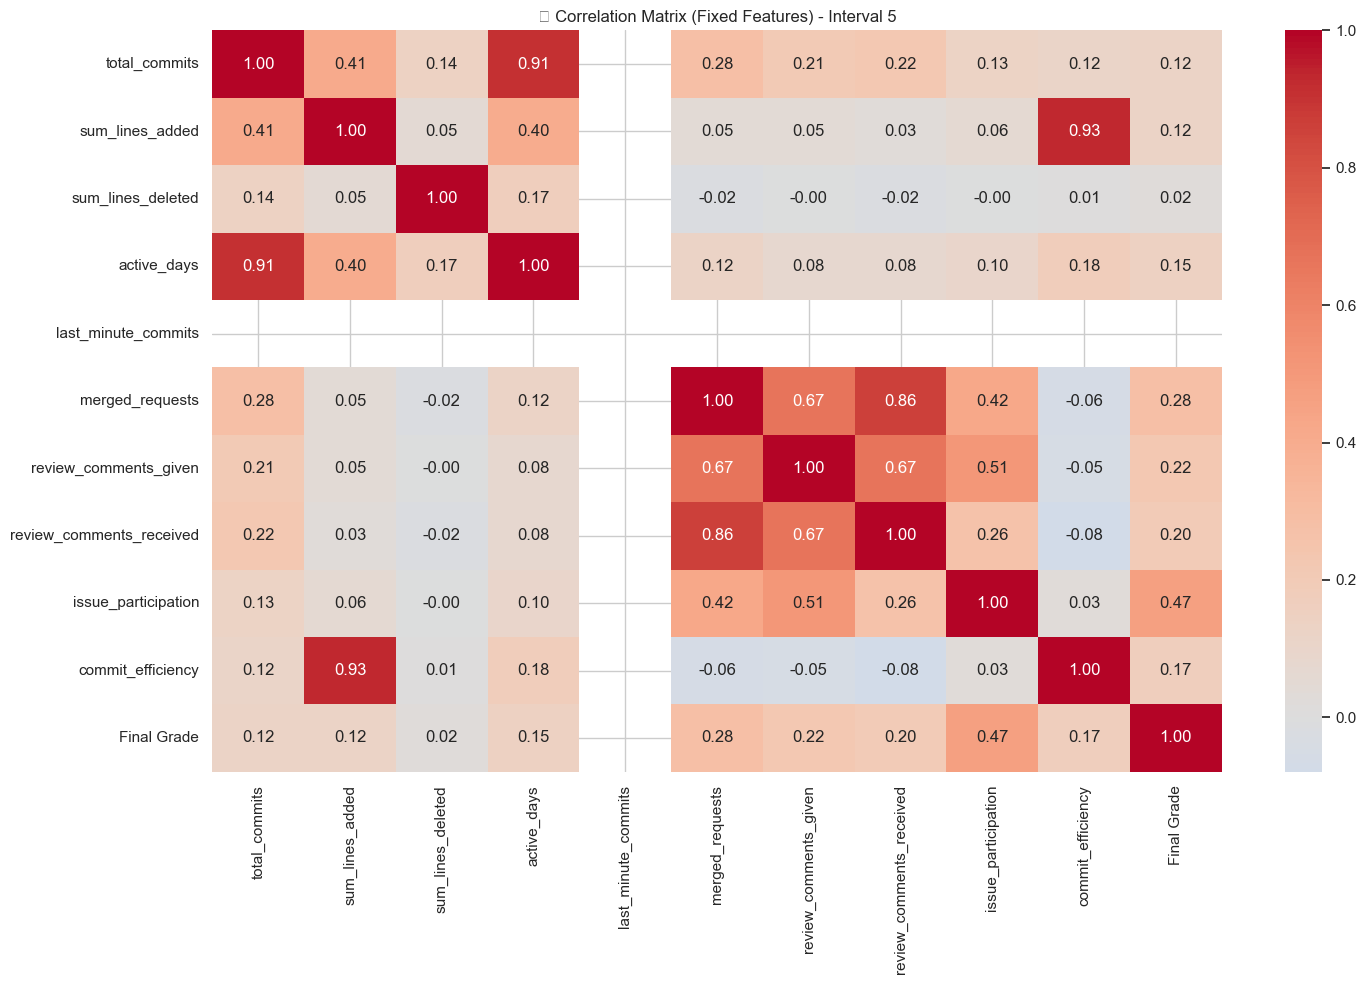

📉 Remoção de outliers (por feature): 59 ➝ 0 linhas
⚠️ Poucos dados após limpeza no Intervalo 5, a usar o dataset original sem remover outliers.


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


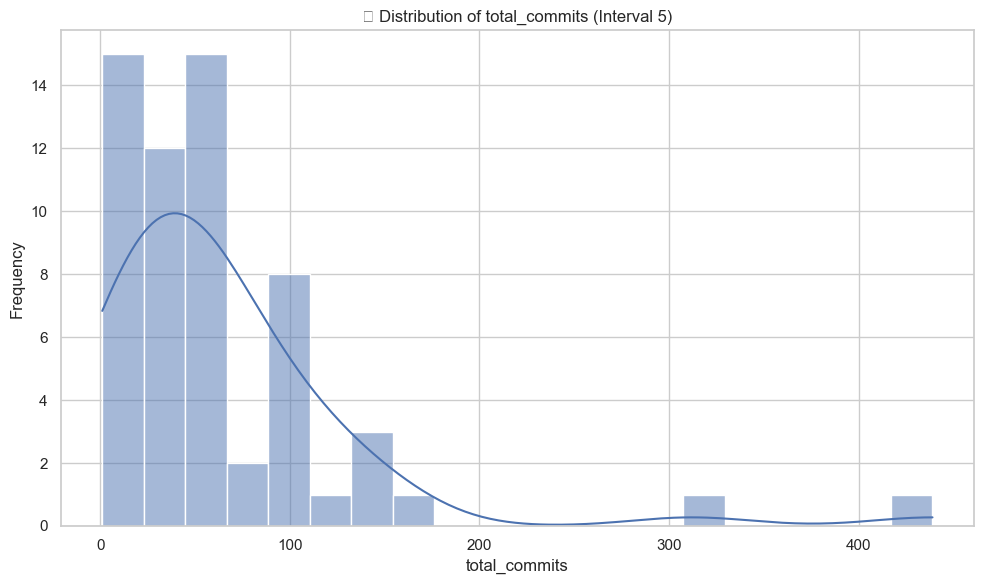

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


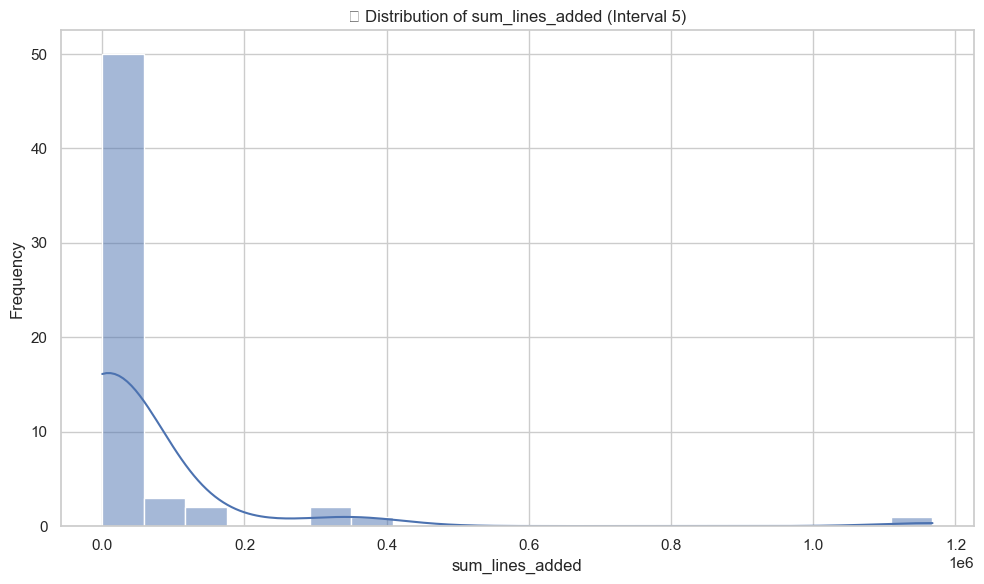

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


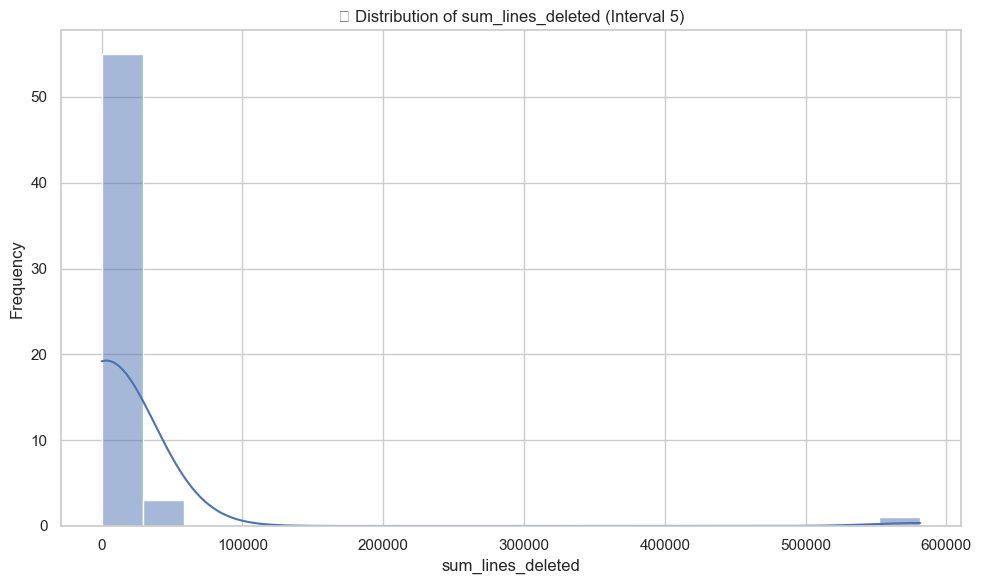

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


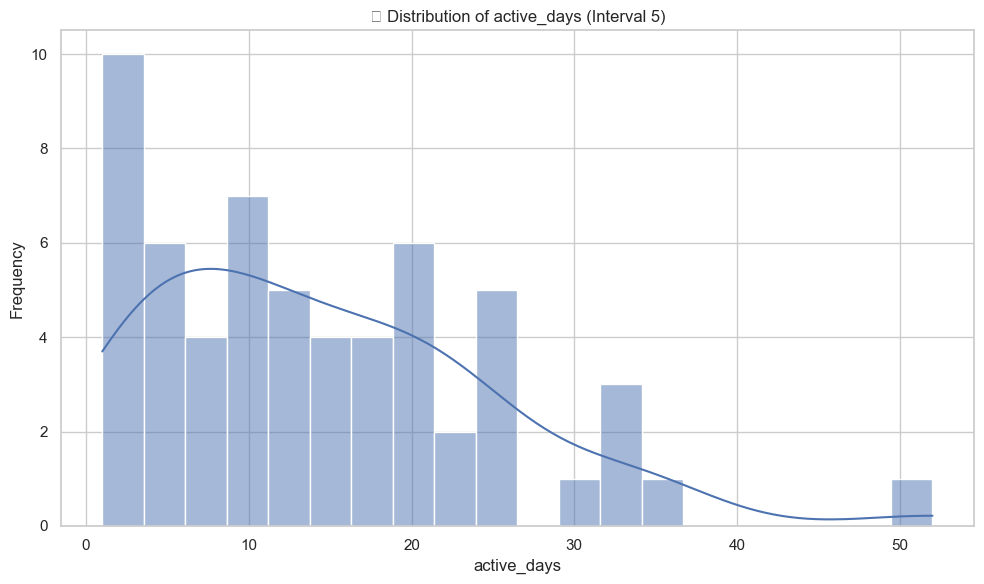

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


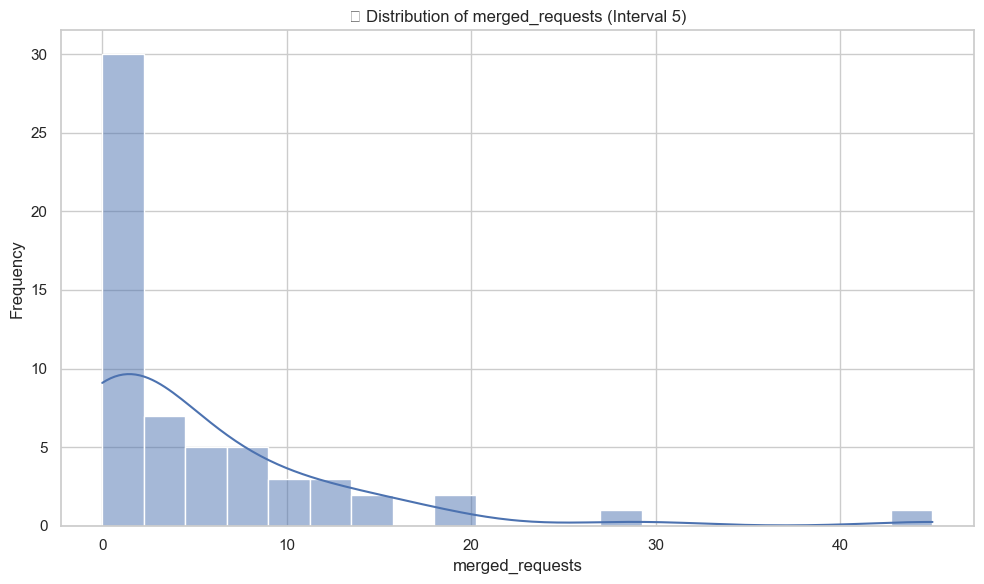

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


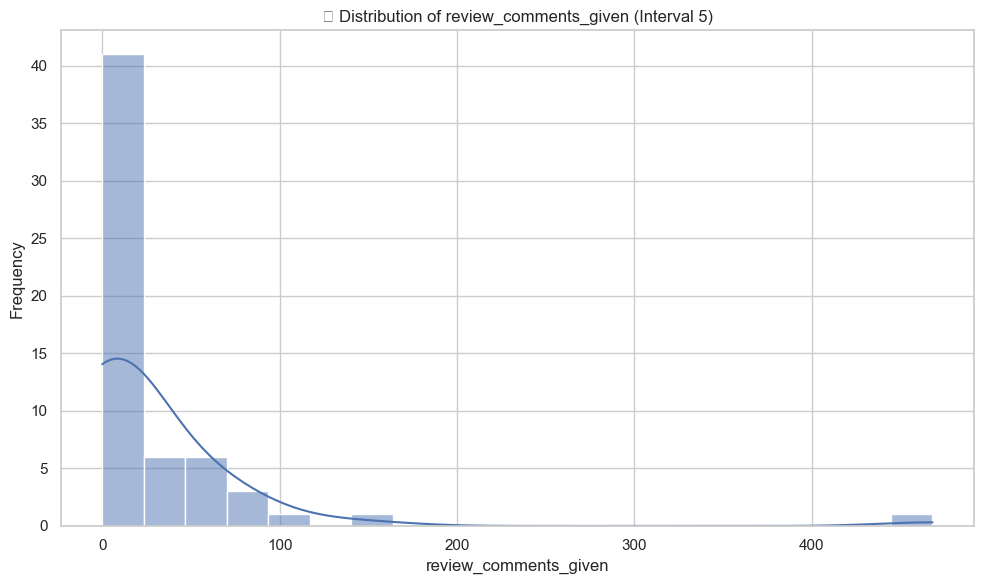

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:100: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


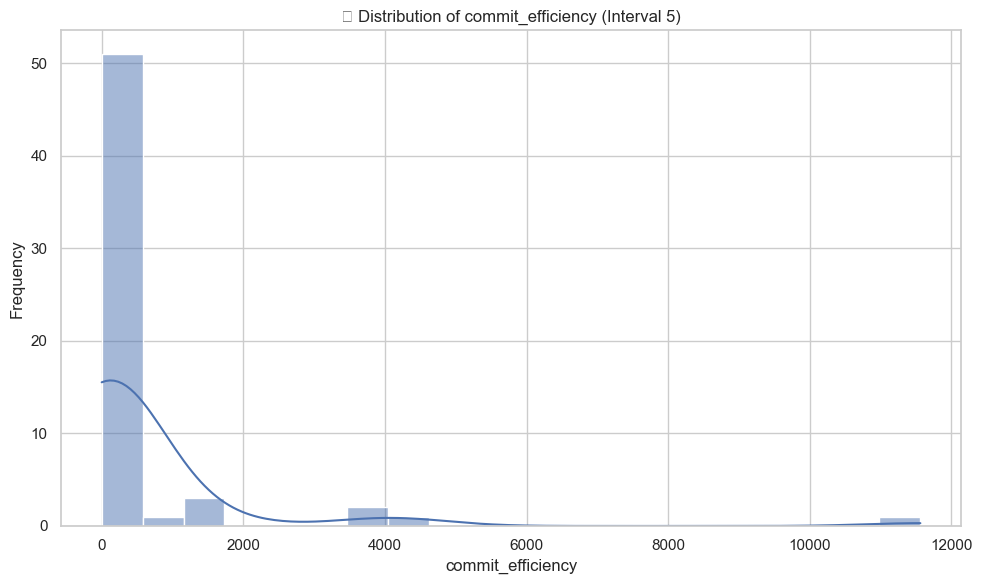

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


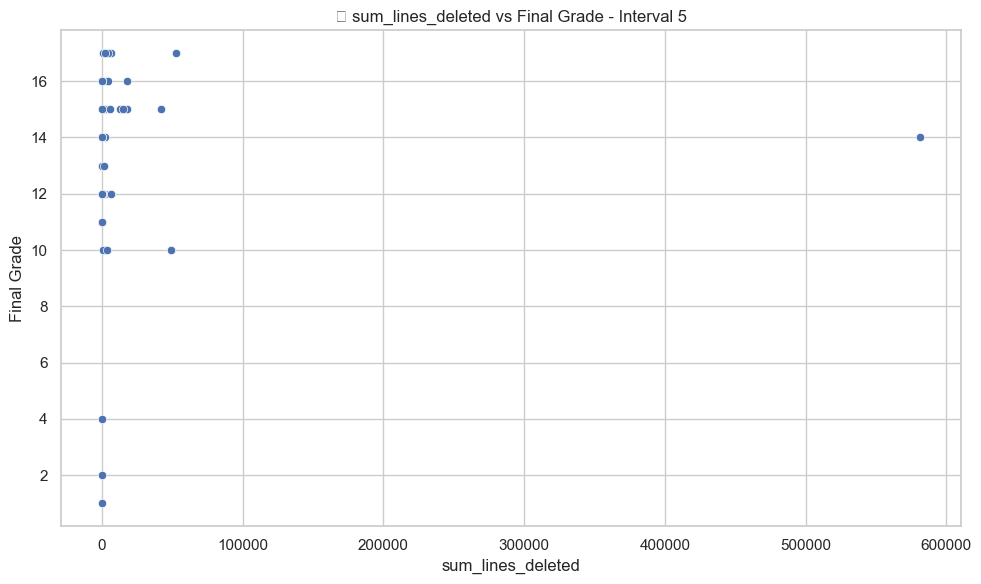

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


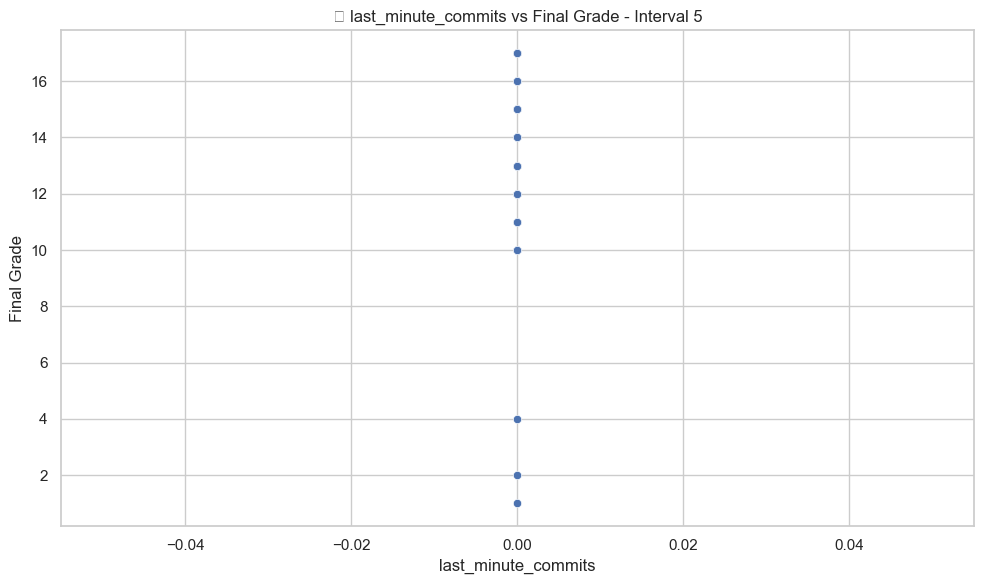

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


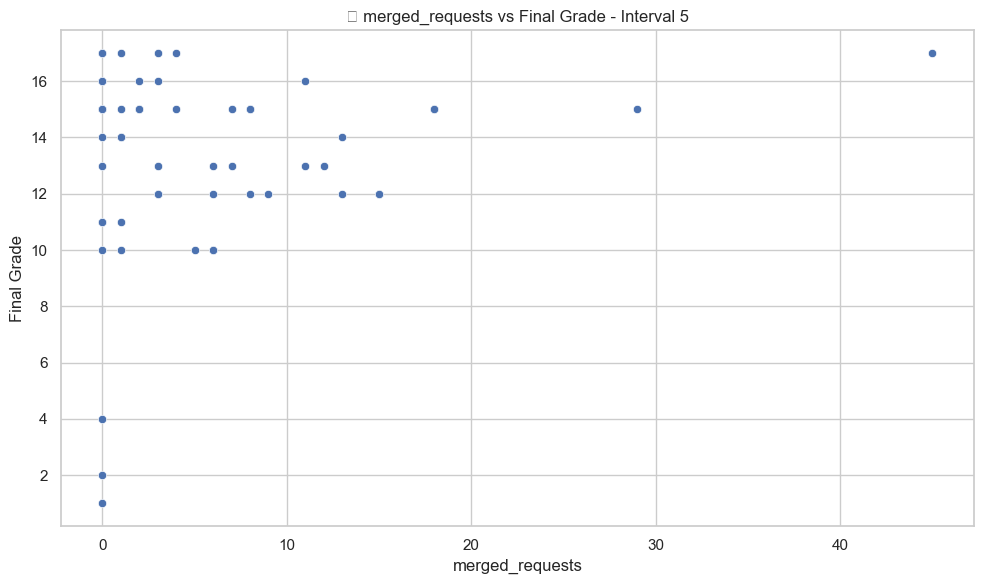

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


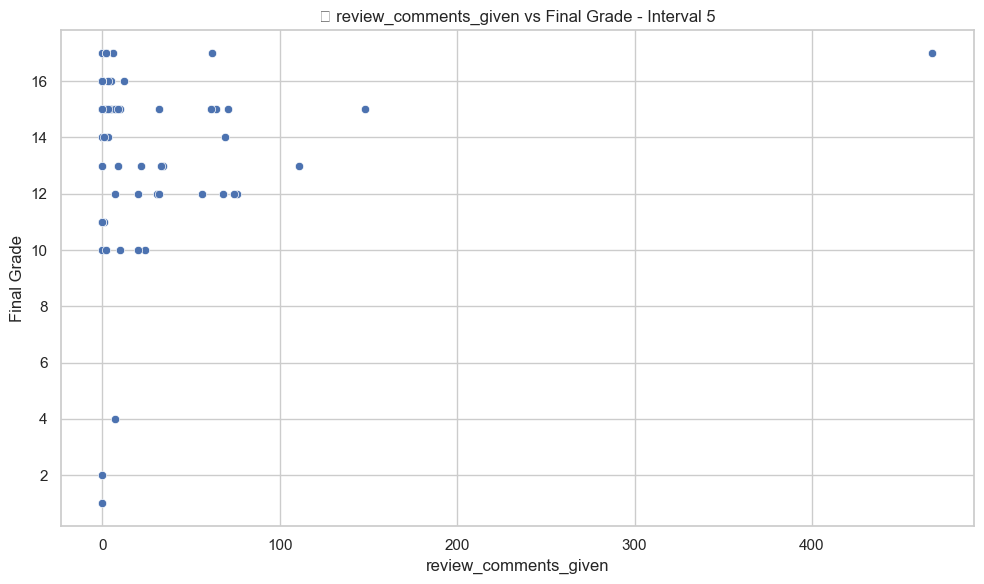

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


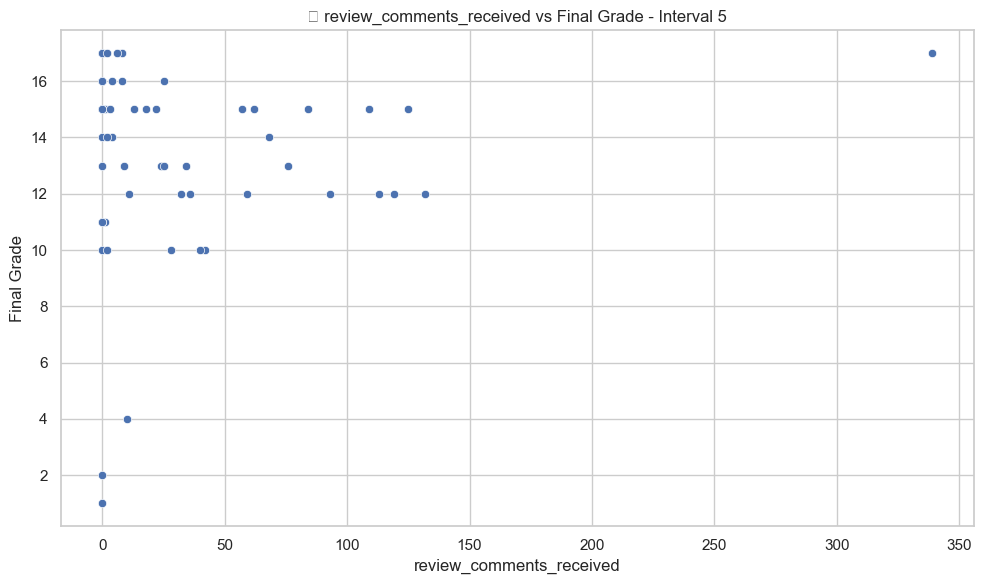

/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:112: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


/var/folders/50/xm41lf691994b3kgc2pynbhw0000gn/T/ipykernel_36902/1699905507.py:124: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/lucianarocha/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


In [8]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Configuration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Lista de features comuns a todos os intervalos
selected_features = [
    "total_commits",
    "sum_lines_added",
    "sum_lines_deleted",
    "active_days",
    "last_minute_commits",
    "merged_requests",
    "review_comments_given",
    "review_comments_received",
    "issue_participation",
    "commit_efficiency"  # se já estiver calculada no CSV
]

# Loop over the 5 intervals
for i in range(1, 6):
    print("="*80)
    print(f"📁 EDA for Interval {i}")
    print("="*80)
    
    # Load dataset
    file_path = f"student_features_interval_{i}.csv"
    df = pd.read_csv(file_path)

    # ------------------------------
    # 0. Calcula commit_efficiency se não existir
    if "commit_efficiency" not in df.columns and "sum_lines_added" in df.columns and "total_commits" in df.columns:
        df["commit_efficiency"] = df["sum_lines_added"] / df["total_commits"].replace(0, np.nan)

    # ------------------------------
    # 1. Check for duplicates
    duplicates = df[df.duplicated()]
    print(f"🔁 Duplicates found in Interval {i}: {len(duplicates)}")
    if not duplicates.empty:
        display(duplicates)

    # ------------------------------
    # 2. Correlation matrix (com features fixas + Final Grade)
    cols_for_corr = [f for f in selected_features + ["Final Grade"] if f in df.columns]
    corr = df[cols_for_corr].select_dtypes(include='number').corr()
    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title(f"🔗 Correlation Matrix (Fixed Features) - Interval {i}")
    plt.tight_layout()
    plt.show()

    # ------------------------------
    # 3. Isola apenas as colunas de interesse e a target
    df_sub = df[cols_for_corr].dropna()

    # ------------------------------
    # 4. Remoção de outliers (z‑score nas features)
    # Remoção de outliers: apenas para features numéricas
    df_no_outliers = df_sub.copy()
    for feature in features_in_data:
        z = np.abs(zscore(df_no_outliers[feature], nan_policy='omit'))
        df_no_outliers = df_no_outliers[z < 3]

    print(f"📉 Remoção de outliers (por feature): {df_sub.shape[0]} ➝ {df_no_outliers.shape[0]} linhas")

    # Saltar remoção de outliers se perdermos tudo
    if df_no_outliers.shape[0] < 10:  # por exemplo
        print(f"⚠️ Poucos dados após limpeza no Intervalo {i}, a usar o dataset original sem remover outliers.")
        df_no_outliers = df_sub.copy()


    # ------------------------------
    # 5. Normalização (apenas features selecionadas)
    scaler = StandardScaler()
    features_in_data = [f for f in selected_features if f in df_no_outliers.columns]
    if df_no_outliers.shape[0] == 0 or len(features_in_data) == 0:
        print(f"⚠️ Intervalo {i}: Sem dados após remoção de outliers ou sem features disponíveis. A saltar...")
        continue

    X = scaler.fit_transform(df_no_outliers[features_in_data])

    y = df_no_outliers["Final Grade"].values

    # ------------------------------
    # 6. Visualização das distribuições após limpeza
    for feature in selected_features:
        if feature in df_no_outliers.columns:
            plt.figure()
            sns.histplot(df_no_outliers[feature], kde=True, bins=20)
            plt.title(f"📊 Distribution of {feature} (Interval {i})")
            plt.xlabel(feature)
            plt.ylabel("Frequency")
            plt.tight_layout()
            plt.show()

    # ------------------------------
    # 7. Feature vs Grade (scatterplots)
    for feature in selected_features:
        if feature in df_no_outliers.columns:
            plt.figure()
            sns.scatterplot(x=df_no_outliers[feature], y=df_no_outliers["Final Grade"])
            plt.title(f"📈 {feature} vs Final Grade - Interval {i}")
            plt.xlabel(feature)
            plt.ylabel("Final Grade")
            plt.tight_layout()
            plt.show()

    # ------------------------------
    # 8. Boxplot: Grade by Group (se existir)
    if "group_id" in df.columns:
        temp = df_no_outliers.copy()
        temp["group_id"] = df.loc[temp.index, "group_id"]
        plt.figure()
        sns.boxplot(x=temp["group_id"], y=temp["Final Grade"])
        plt.title(f"📦 Final Grade by Group - Interval {i}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [ ]:
# Imports
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Features selecionadas
selected_features = [
    "total_issues_created", "total_issues_assigned",
    "issues_resolved", "issue_participation"
]

# Recolher os ficheiros de intervalo 1 a 5
all_files = sorted(glob.glob("student_features_interval_*.csv"))

# Guardar resultados
results = []

# Loop por intervalo
for i, file_path in enumerate(all_files, start=1):
    print(f"\n📁 Interval {i}: {file_path}")
    
    # 1. Carregar dados
    df = pd.read_csv(file_path)
    df = df.dropna(subset=selected_features + ["Final Grade"])

    # 2. Separar X e y
    X_all = df.drop(columns=["Final Grade", "project_id", "group_id", "mention_handle", "interval"], errors='ignore')
    y = df["Final Grade"]

    # 3. Normalizar todas as features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_all)

    # 4. Selecionar apenas as 4 features alvo
    selected_indices = [X_all.columns.get_loc(col) for col in selected_features]
    X_selected = X_scaled[:, selected_indices]

    # 5. Dividir treino/teste
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # 6. Regressão Linear
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_preds = lr_model.predict(X_test)

    results.append({
        "Interval": i,
        "Model": "Linear Regression",
        "MSE": mean_squared_error(y_test, lr_preds),
        "MAE": mean_absolute_error(y_test, lr_preds),
        "R2": r2_score(y_test, lr_preds)
    })

    # 7. Rede Neural
    nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
    nn_model.fit(X_train, y_train)
    nn_preds = nn_model.predict(X_test)

    results.append({
        "Interval": i,
        "Model": "Neural Network",
        "MSE": mean_squared_error(y_test, nn_preds),
        "MAE": mean_absolute_error(y_test, nn_preds),
        "R2": r2_score(y_test, nn_preds)
    })

# 8. Mostrar resultados
results_df = pd.DataFrame(results)
display(results_df)



In [3]:
import joblib
joblib.dump(nn_model, "NeuralNetwork_interval5.pkl")